In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!unzip gdrive/MyDrive/Dataset/ptb.zip

In [ ]:
!pip -q install wfdb==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
import sys
import os
import glob
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import wfdb


# **MYOCARDIAL INFRACTION**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre', sampfrom = 0, sampto= 115200, channels=[0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array


In [ ]:
wfdb.plot_wfdb(record=record, figsize=(15,8))

In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

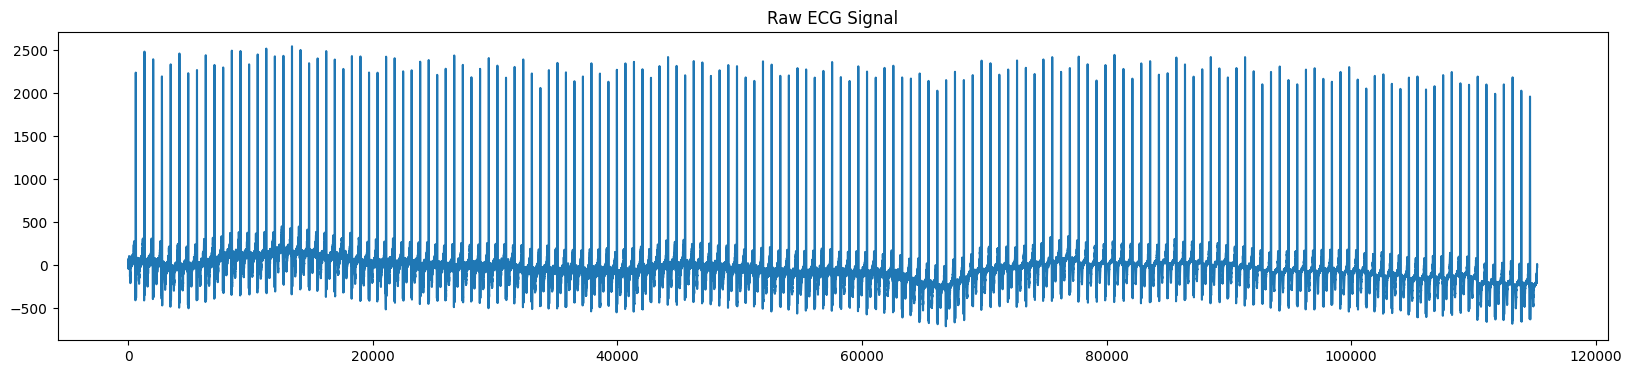

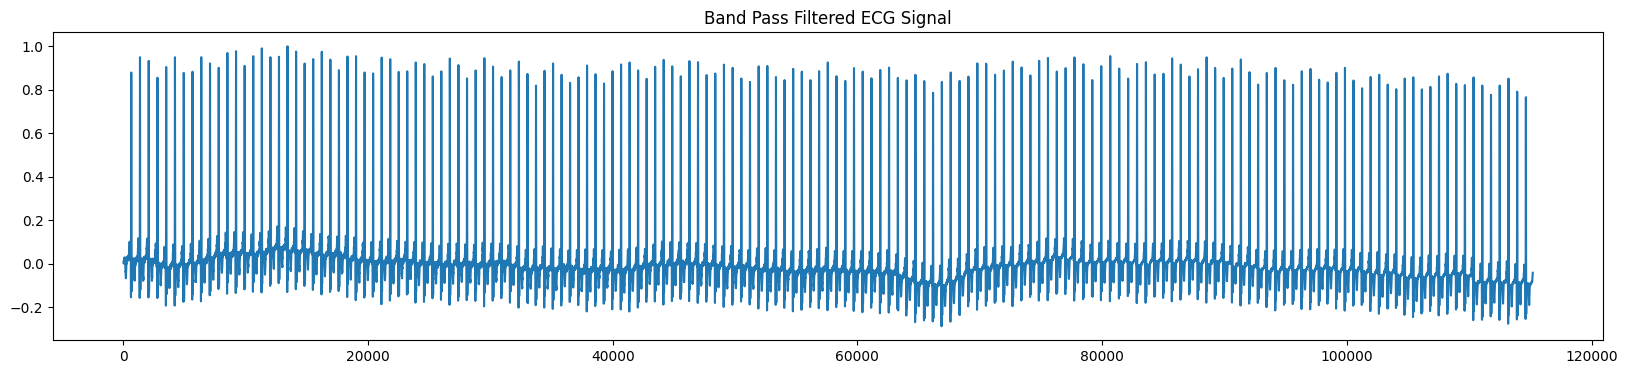

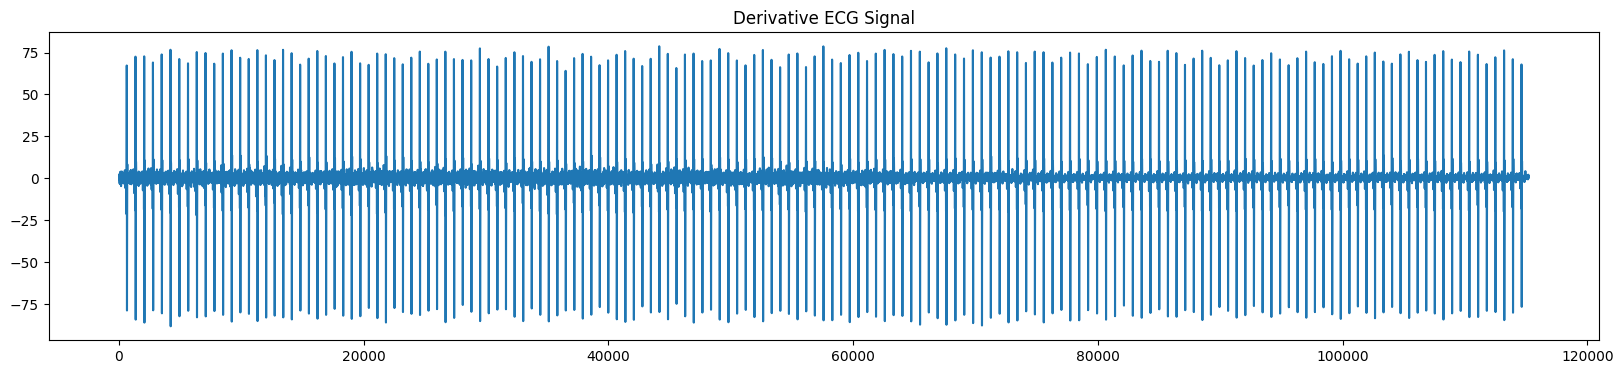

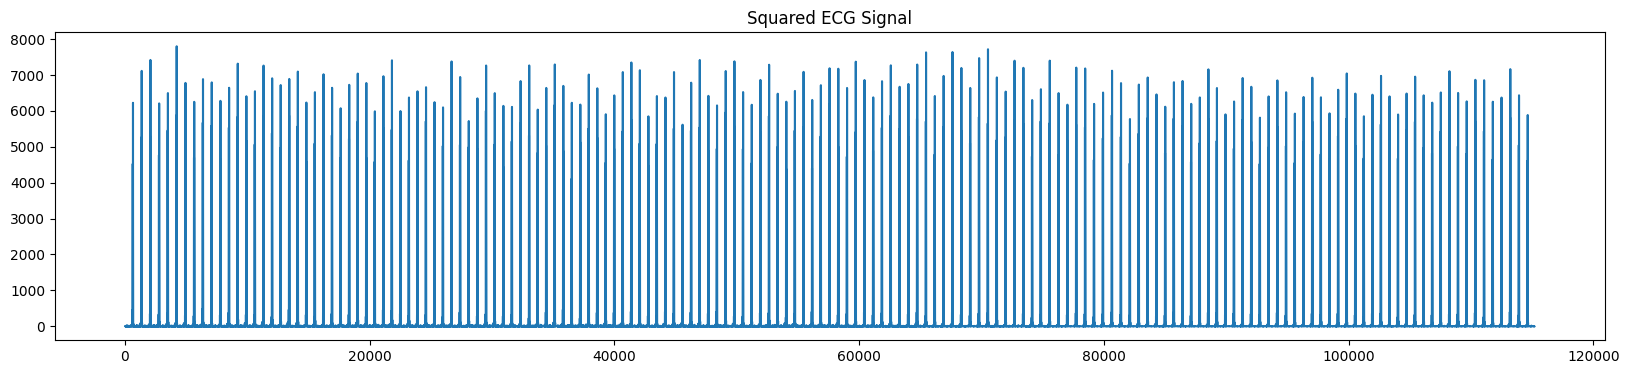

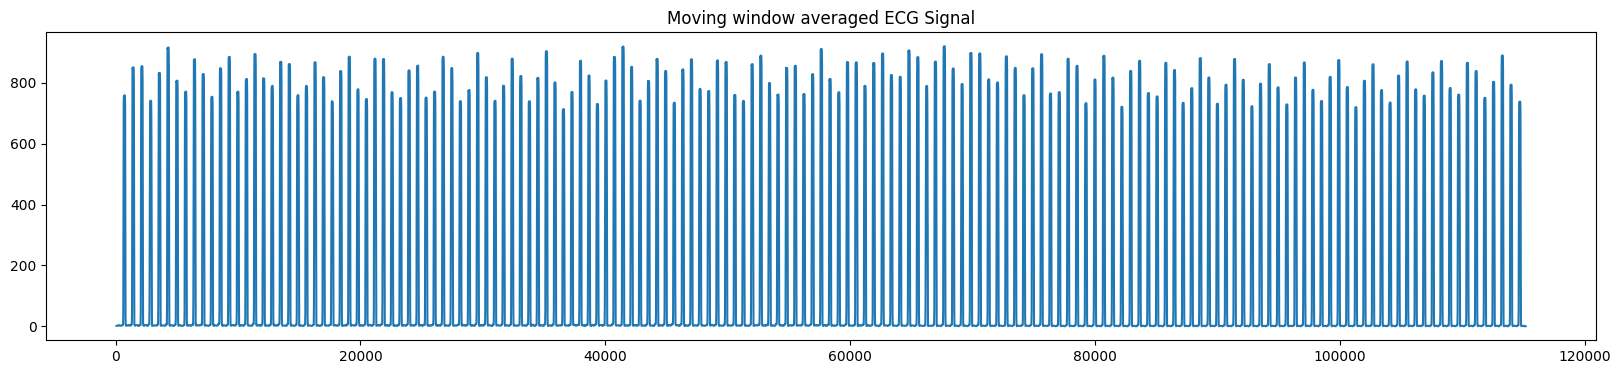

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
pip install biosppy

In [ ]:
import biosppy

In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0046lre', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0046lre', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient014/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient014/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['MI/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

  2%|▏         | 3/162 [00:00<00:06, 25.80it/s]

img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_1.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_2.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_3.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



  4%|▎         | 6/162 [00:00<00:07, 21.50it/s]

img writtten Images_DATABASE/MI/fig_46lre_4.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_5.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_6.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_7.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



  7%|▋         | 11/162 [00:00<00:07, 19.01it/s]

img writtten Images_DATABASE/MI/fig_46lre_8.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_9.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_10.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_11.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



  9%|▉         | 15/162 [00:00<00:07, 18.89it/s]

img writtten Images_DATABASE/MI/fig_46lre_12.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_13.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_14.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_15.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 12%|█▏        | 19/162 [00:01<00:08, 17.64it/s]

img writtten Images_DATABASE/MI/fig_46lre_16.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_17.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_18.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_19.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 14%|█▍        | 23/162 [00:01<00:07, 18.12it/s]

img writtten Images_DATABASE/MI/fig_46lre_20.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_21.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_22.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_23.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 17%|█▋        | 27/162 [00:01<00:07, 17.74it/s]

img writtten Images_DATABASE/MI/fig_46lre_24.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_25.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_26.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_27.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 19%|█▉        | 31/162 [00:01<00:07, 18.10it/s]

img writtten Images_DATABASE/MI/fig_46lre_28.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_29.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_30.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_31.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 22%|██▏       | 35/162 [00:01<00:06, 18.44it/s]

img writtten Images_DATABASE/MI/fig_46lre_32.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_33.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_34.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_35.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 24%|██▍       | 39/162 [00:02<00:06, 18.68it/s]

img writtten Images_DATABASE/MI/fig_46lre_36.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_37.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_38.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_39.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 27%|██▋       | 43/162 [00:02<00:06, 18.87it/s]

img writtten Images_DATABASE/MI/fig_46lre_40.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_41.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_42.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_43.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 29%|██▉       | 47/162 [00:02<00:06, 17.18it/s]

img writtten Images_DATABASE/MI/fig_46lre_44.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_45.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_46.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 32%|███▏      | 52/162 [00:03<00:17,  6.34it/s]

img writtten Images_DATABASE/MI/fig_46lre_47.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_48.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_49.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_50.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_51.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_52.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 36%|███▌      | 58/162 [00:04<00:09, 11.36it/s]

img writtten Images_DATABASE/MI/fig_46lre_53.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_54.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_55.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_56.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_57.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_58.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 40%|███▉      | 64/162 [00:04<00:06, 15.85it/s]

img writtten Images_DATABASE/MI/fig_46lre_59.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_60.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_61.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_62.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_63.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 41%|████▏     | 67/162 [00:04<00:05, 17.50it/s]

img writtten Images_DATABASE/MI/fig_46lre_64.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_65.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_66.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_67.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_68.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 45%|████▌     | 73/162 [00:04<00:04, 20.86it/s]

img writtten Images_DATABASE/MI/fig_46lre_69.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_70.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_71.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_72.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_73.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_74.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 49%|████▉     | 79/162 [00:05<00:03, 22.72it/s]

img writtten Images_DATABASE/MI/fig_46lre_75.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_76.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_77.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_78.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_79.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 52%|█████▏    | 85/162 [00:05<00:03, 23.73it/s]

img writtten Images_DATABASE/MI/fig_46lre_80.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_81.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_82.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_83.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_84.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_85.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 56%|█████▌    | 91/162 [00:05<00:02, 24.54it/s]

img writtten Images_DATABASE/MI/fig_46lre_86.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_87.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_88.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_89.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_90.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 58%|█████▊    | 94/162 [00:05<00:02, 23.29it/s]


img writtten Images_DATABASE/MI/fig_46lre_91.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_92.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_93.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_94.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_95.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_96.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre


 62%|██████▏   | 100/162 [00:05<00:02, 24.07it/s]

img writtten Images_DATABASE/MI/fig_46lre_97.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_98.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_99.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_100.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_101.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 65%|██████▌   | 106/162 [00:06<00:02, 24.23it/s]

img writtten Images_DATABASE/MI/fig_46lre_102.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_103.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_104.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_105.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_106.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_107.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 69%|██████▉   | 112/162 [00:06<00:02, 24.78it/s]

img writtten Images_DATABASE/MI/fig_46lre_108.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_109.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_110.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_111.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_112.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 71%|███████   | 115/162 [00:06<00:01, 24.43it/s]

img writtten Images_DATABASE/MI/fig_46lre_113.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_114.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_115.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 75%|███████▍  | 121/162 [00:07<00:03, 12.74it/s]

img writtten Images_DATABASE/MI/fig_46lre_116.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_117.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_118.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_119.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_120.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_121.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 78%|███████▊  | 127/162 [00:07<00:02, 16.78it/s]

img writtten Images_DATABASE/MI/fig_46lre_122.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_123.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_124.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_125.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_126.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 82%|████████▏ | 133/162 [00:07<00:01, 20.44it/s]

img writtten Images_DATABASE/MI/fig_46lre_127.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_128.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_129.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_130.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_131.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_132.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 86%|████████▌ | 139/162 [00:08<00:00, 23.67it/s]

img writtten Images_DATABASE/MI/fig_46lre_133.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_134.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_135.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_136.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_137.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_138.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 90%|████████▉ | 145/162 [00:08<00:00, 25.28it/s]

img writtten Images_DATABASE/MI/fig_46lre_139.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_140.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_141.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_142.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_143.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_144.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 93%|█████████▎| 151/162 [00:08<00:00, 25.88it/s]

img writtten Images_DATABASE/MI/fig_46lre_145.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_146.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_147.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_148.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_149.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_150.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



 97%|█████████▋| 157/162 [00:08<00:00, 26.27it/s]

img writtten Images_DATABASE/MI/fig_46lre_151.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_152.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_153.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_154.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_155.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_156.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre



100%|██████████| 1/1 [00:08<00:00,  8.90s/it]

img writtten Images_DATABASE/MI/fig_46lre_157.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_158.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_159.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img writtten Images_DATABASE/MI/fig_46lre_160.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient014/s0046lre


Number of images in each directory=[991, 986, 140, 407, 88, 44, 679, 74, 303, 834, 37, 112] and total number of images=4695


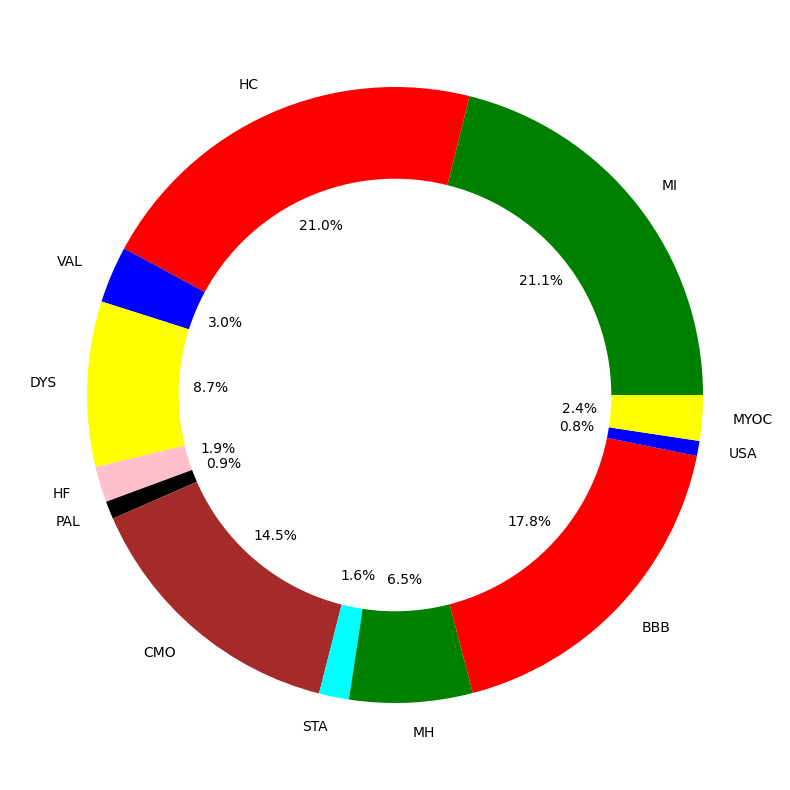

In [ ]:
# count the length of different directory inside dataset
Database_DIR = 'Images_DATABASE/'
image_dirs = ['MI/', 'HC/', 'VAL/', 'DYS/', 'HF/', 'PAL/', 'CMO/', 'STA/', 'MH/', 'BBB/', 'USA/', 'MYOC/']

no_of_files_in_dir=[]
for image_dir in image_dirs:
    path, dirs, files = next(os.walk(os.path.join(Database_DIR,image_dir)))
    no_of_files_in_dir.append(len(files)) 

print('Number of images in each directory={} and total number of images={}'.format(no_of_files_in_dir, sum(no_of_files_in_dir)))

labels = ['MI', 'HC', 'VAL', 'DYS', 'HF', 'PAL', 'CMO', 'STA', 'MH', 'BBB', 'USA', 'MYOC']
colors = ['green', 'red', 'blue', 'yellow', 'pink', 'black', 'brown', 'cyan', 'green', 'red', 'blue', 'yellow']

plot_pie_chart_of_data(no_of_files_in_dir,labels,colors, 'data_distribution.png')


# **Healhy Control**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient131/s0273lre', sampfrom = 15, sampto=115200 , channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



TypeError: ignored

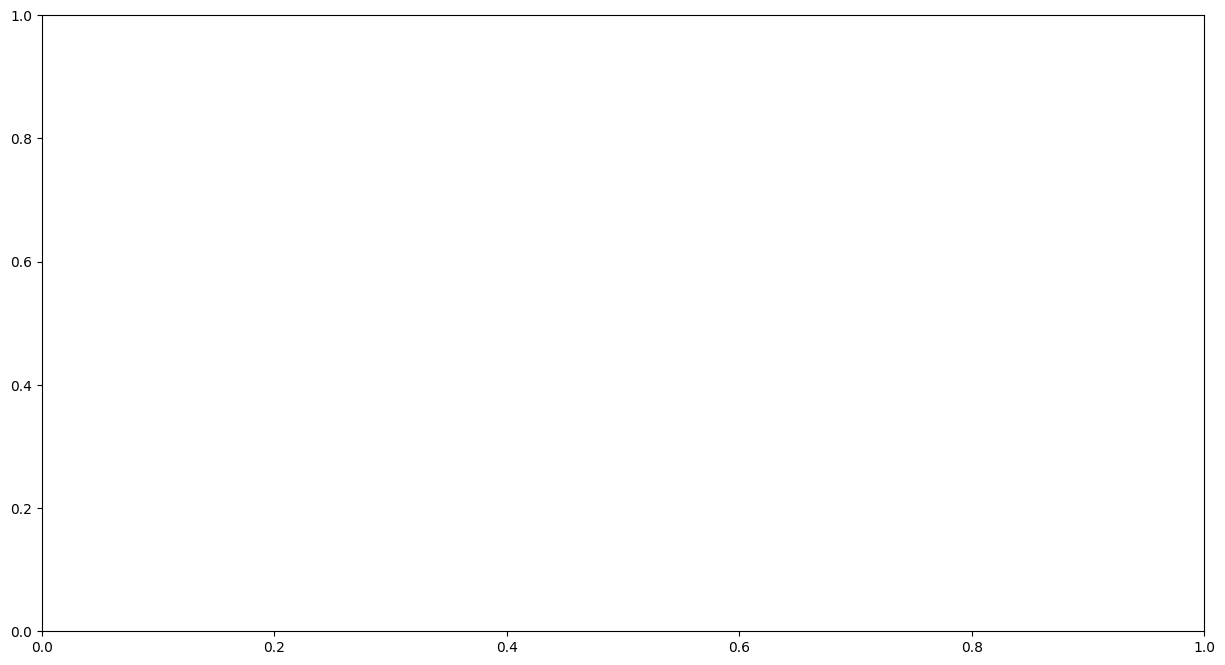

In [ ]:
wfdb.plot_wfdb(record=record, figsize=(15,8))

In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

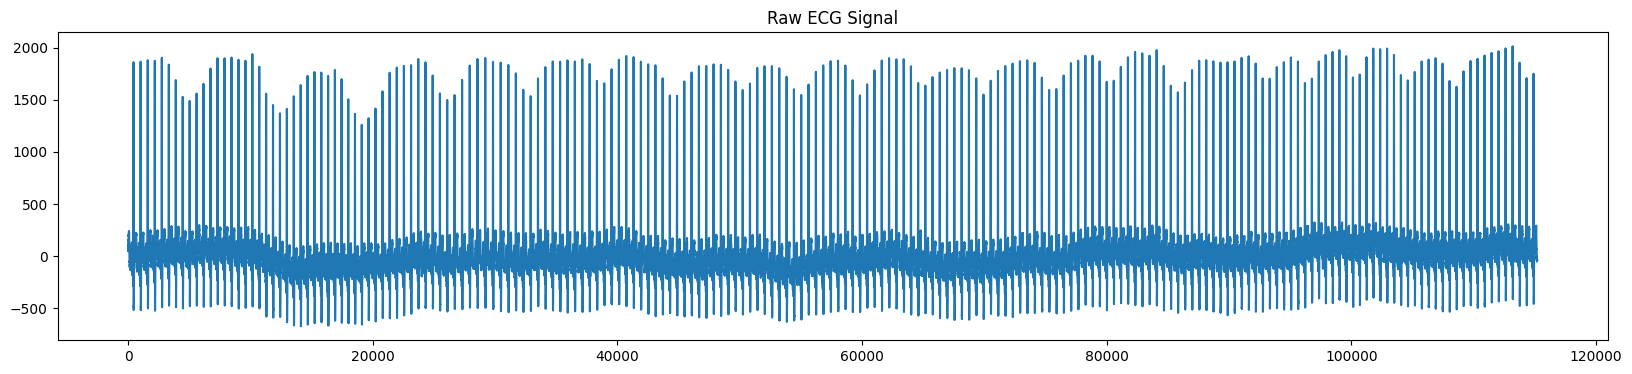

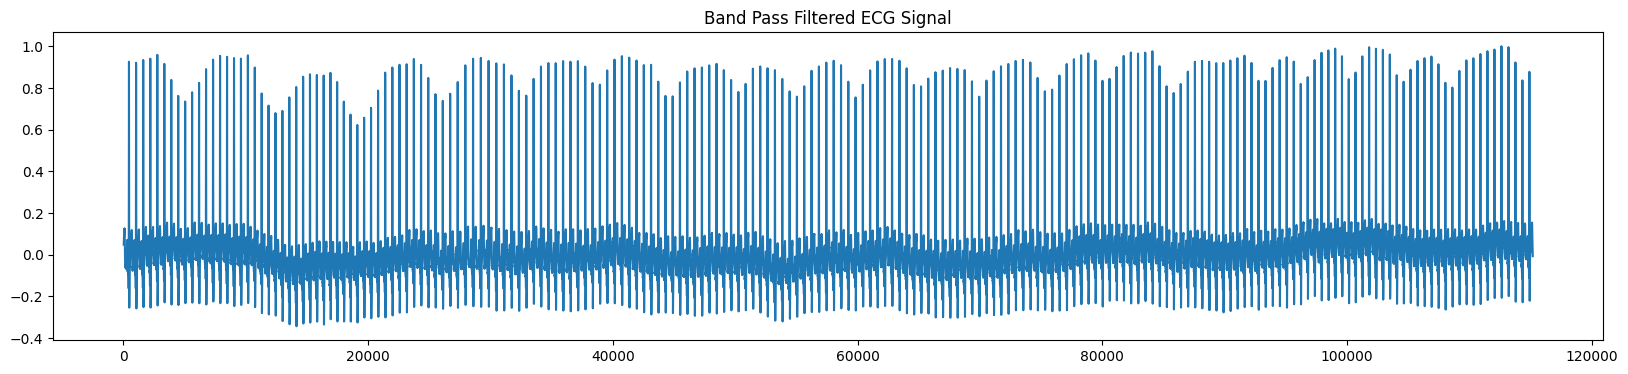

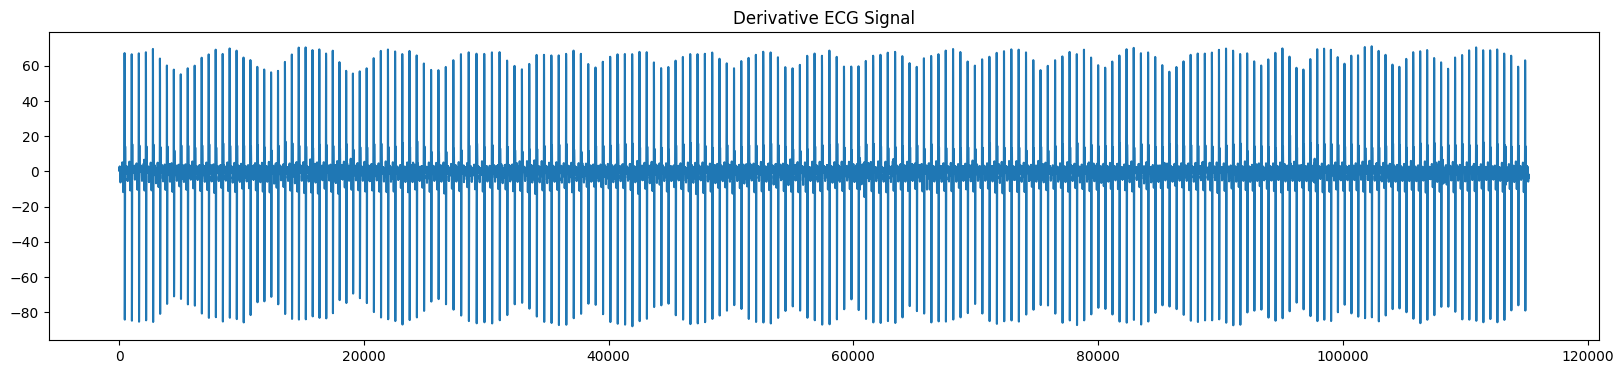

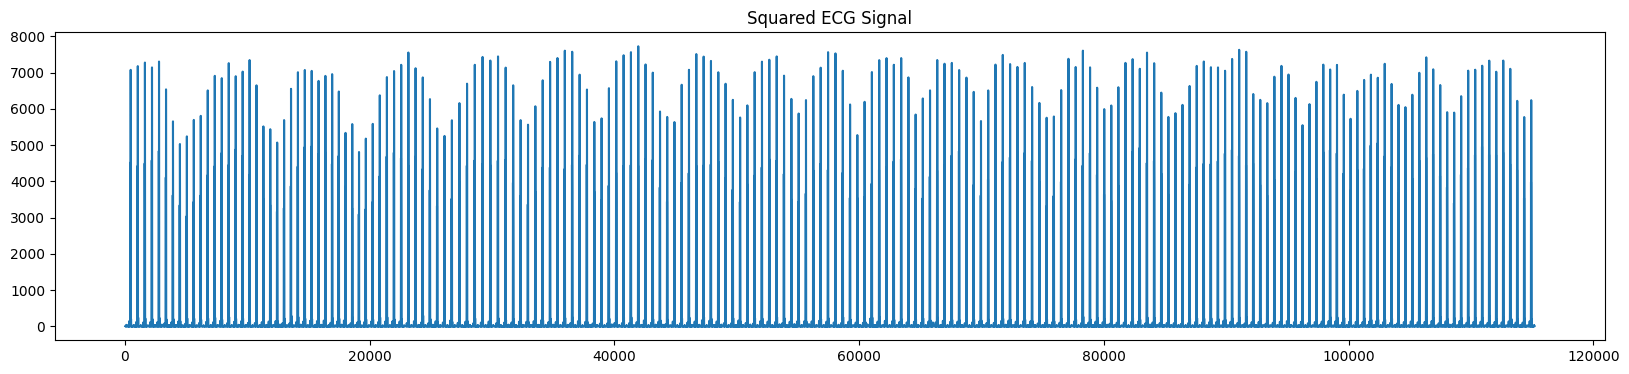

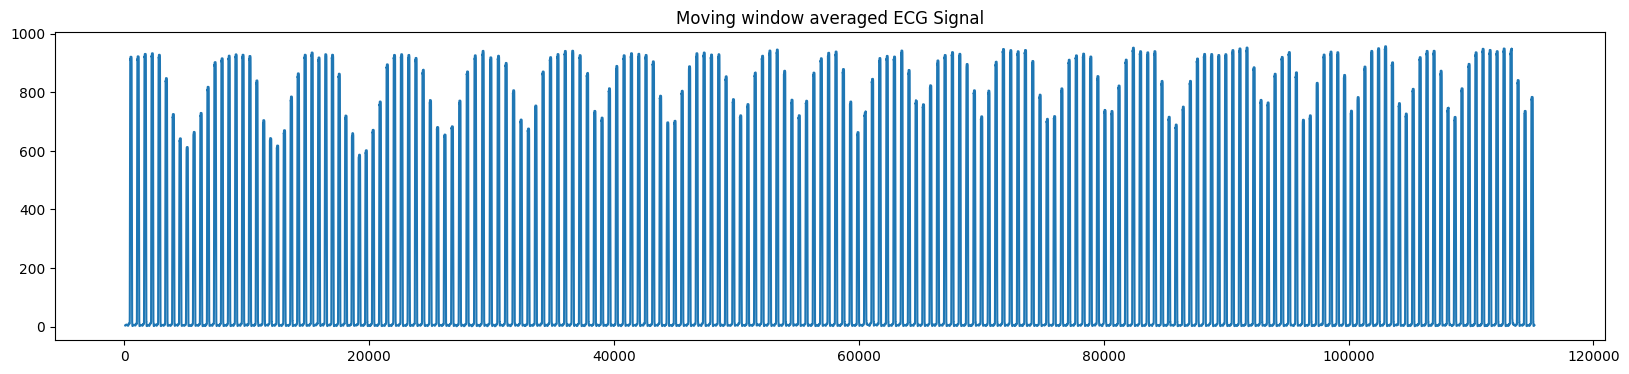

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0273lre', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0273lre', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient131/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient131/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient131/s0273lre']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['HC/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

# **Valvular**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re', sampfrom = 0, sampto=38400 , channels = [0,1]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



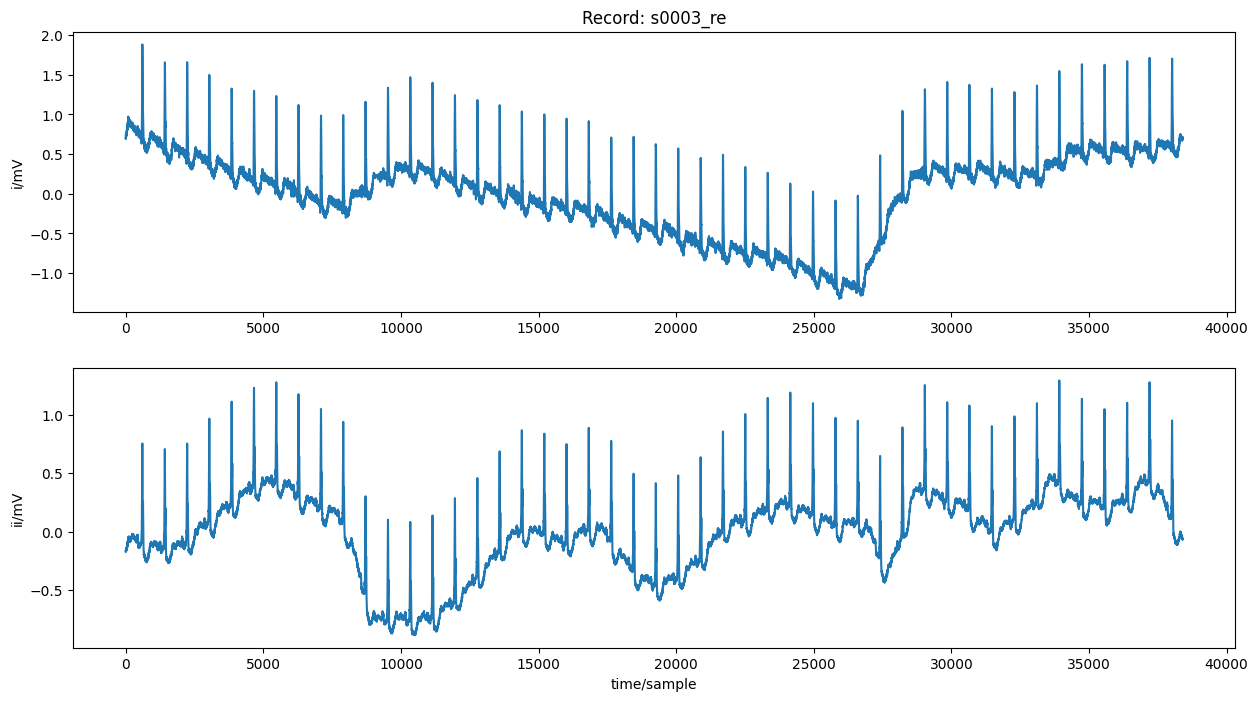

In [ ]:
wfdb.plot_wfdb(record=record, figsize=(15,8))

In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

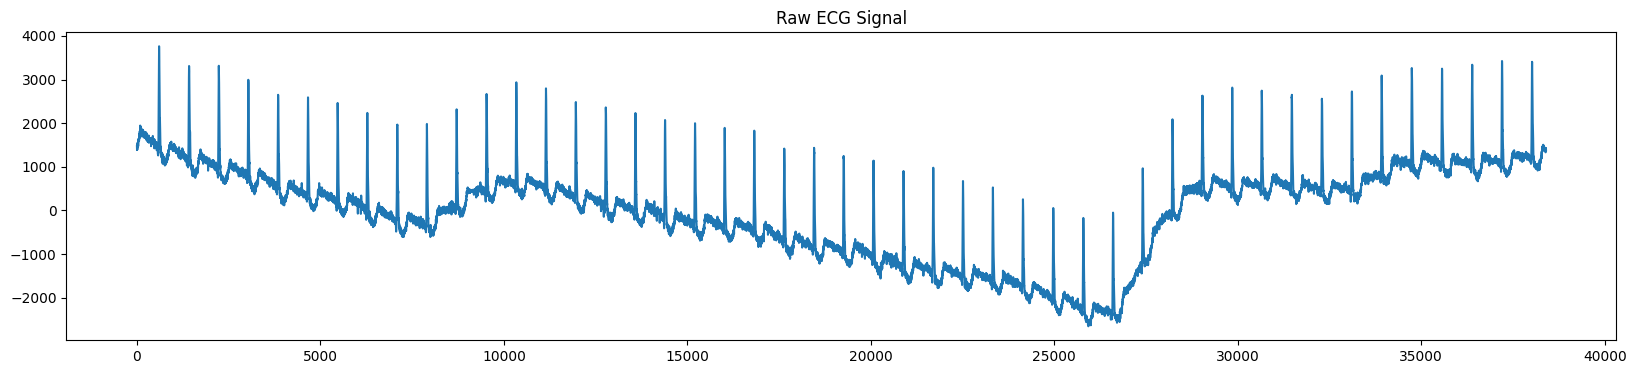

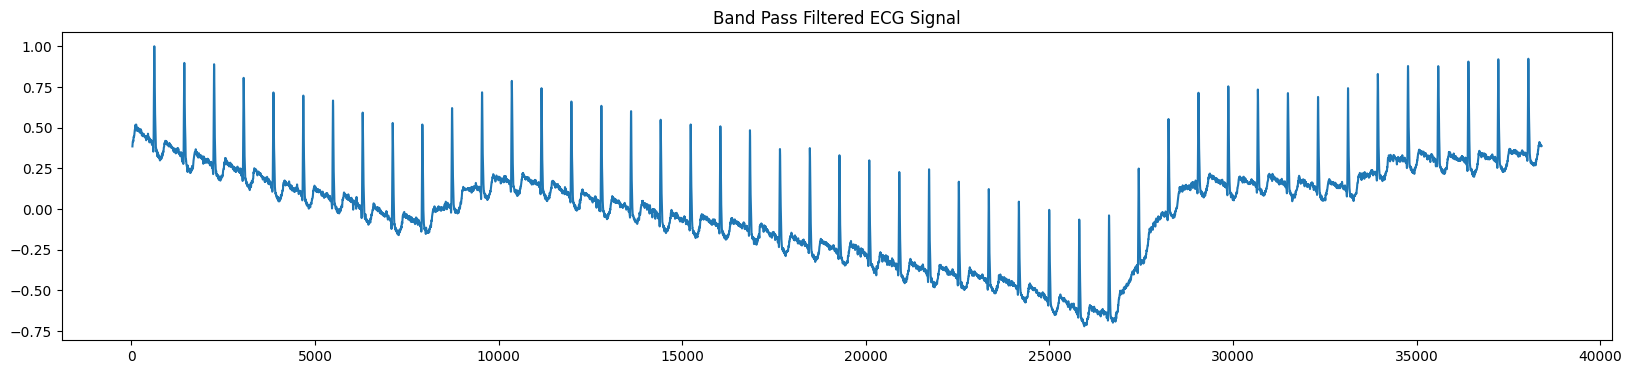

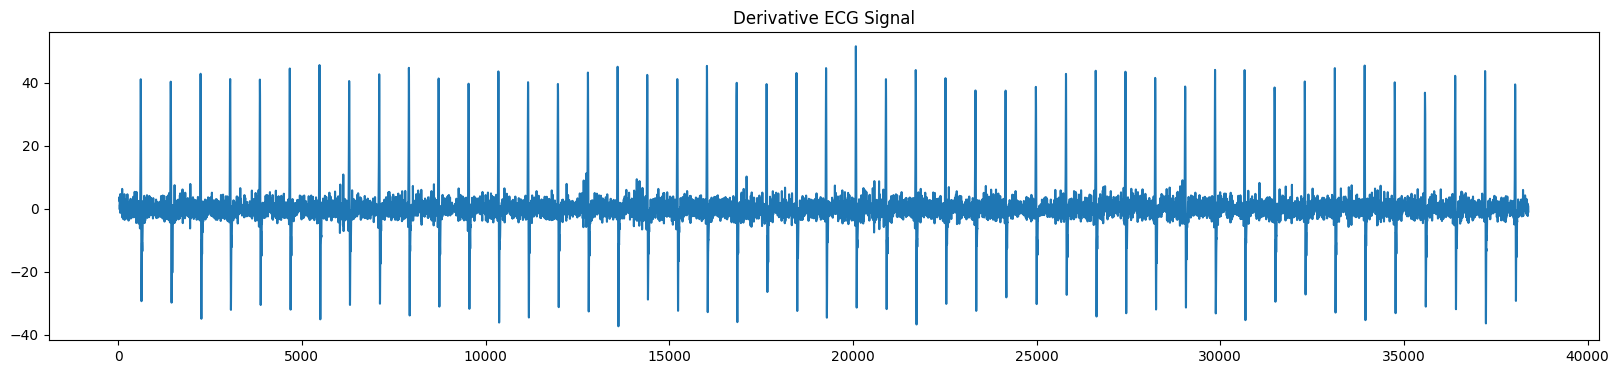

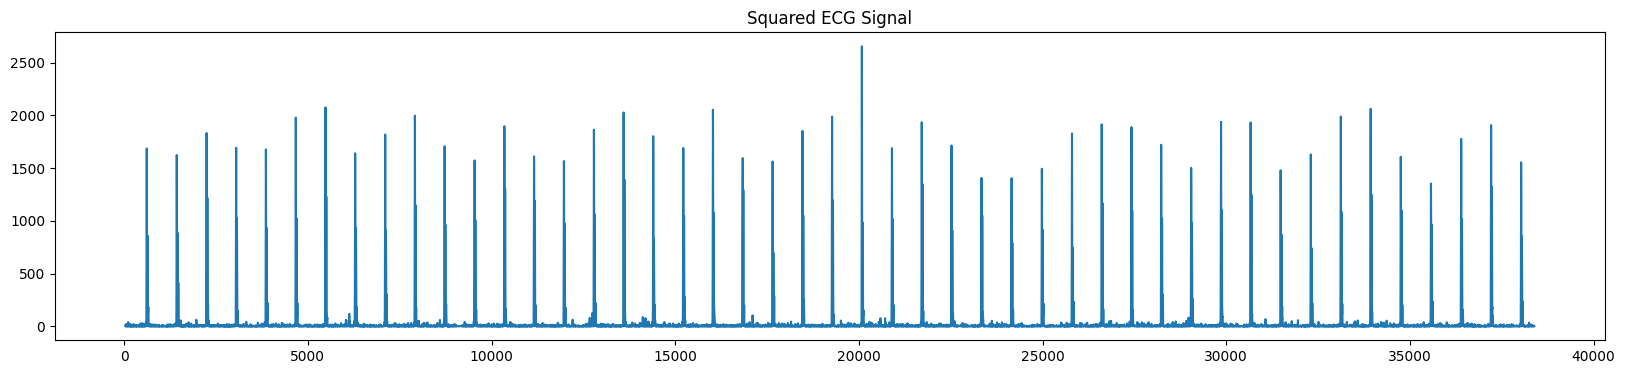

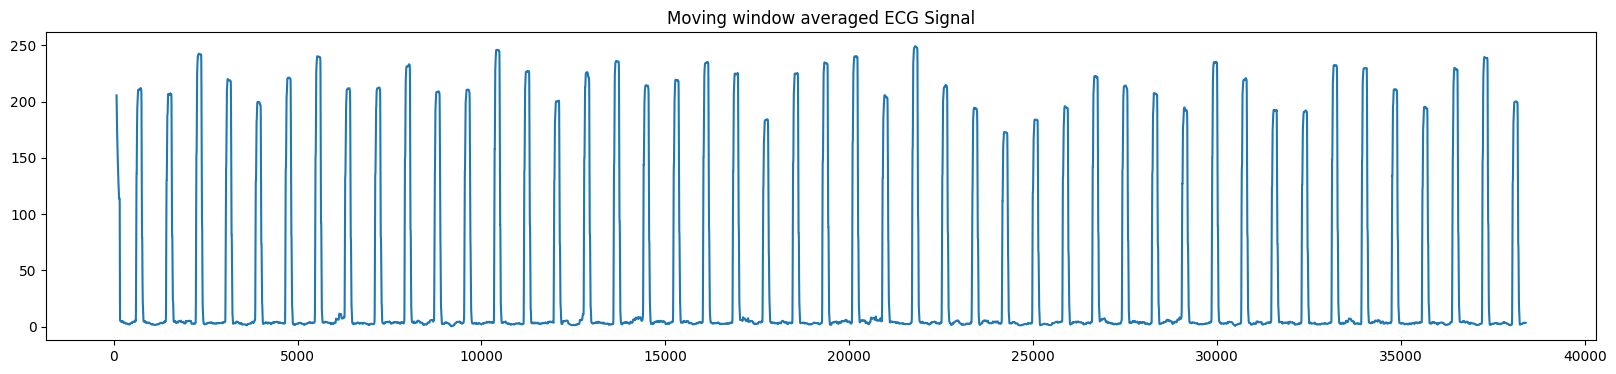

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0003_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0003_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient110/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient110/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['VAL/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

  9%|▊         | 4/47 [00:00<00:01, 39.52it/s]

img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_1.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_2.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_3.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_4.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_5.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_6.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 26%|██▌       | 12/47 [00:00<00:01, 28.63it/s]

img writtten Images_DATABASE/VAL/fig_03_re_7.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_8.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_9.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_10.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_11.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 38%|███▊      | 18/47 [00:00<00:01, 28.64it/s]

img writtten Images_DATABASE/VAL/fig_03_re_12.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_13.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_14.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_15.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_16.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_17.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 51%|█████     | 24/47 [00:00<00:00, 27.45it/s]

img writtten Images_DATABASE/VAL/fig_03_re_18.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_19.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_20.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_21.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_22.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_23.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 57%|█████▋    | 27/47 [00:00<00:00, 26.84it/s]

img writtten Images_DATABASE/VAL/fig_03_re_24.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_25.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_26.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_27.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_28.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 70%|███████   | 33/47 [00:01<00:01, 13.37it/s]

img writtten Images_DATABASE/VAL/fig_03_re_29.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_30.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_31.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_32.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 74%|███████▍  | 35/47 [00:01<00:00, 13.41it/s]


img writtten Images_DATABASE/VAL/fig_03_re_33.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_34.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_35.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_36.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re


 83%|████████▎ | 39/47 [00:02<00:00, 14.31it/s]

img writtten Images_DATABASE/VAL/fig_03_re_37.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_38.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_39.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 91%|█████████▏| 43/47 [00:02<00:00, 11.98it/s]

img writtten Images_DATABASE/VAL/fig_03_re_40.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_41.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_42.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re



 96%|█████████▌| 45/47 [00:02<00:00, 11.16it/s]

img writtten Images_DATABASE/VAL/fig_03_re_43.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_44.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img writtten Images_DATABASE/VAL/fig_03_re_45.png


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient110/s0003_re


# **DYSTHERMIA**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre', sampfrom = 0, sampto= 115200, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



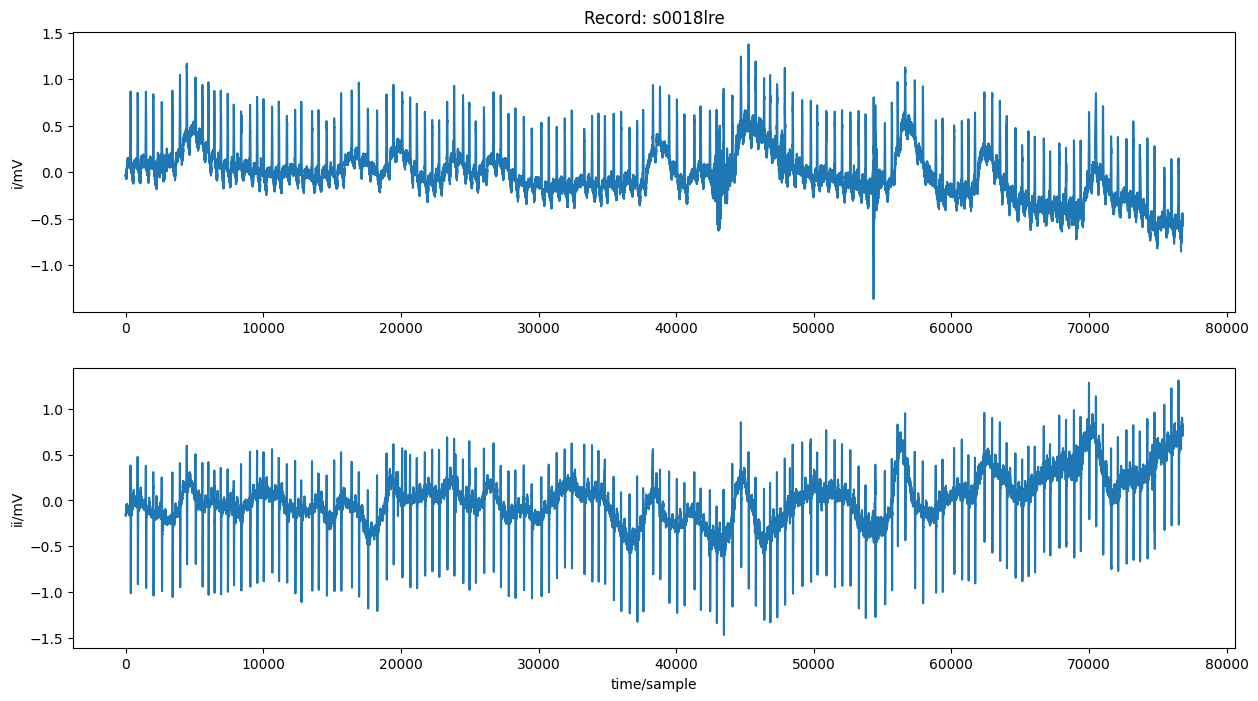

In [ ]:
wfdb.plot_wfdb(record=record, figsize=(15,8))

In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

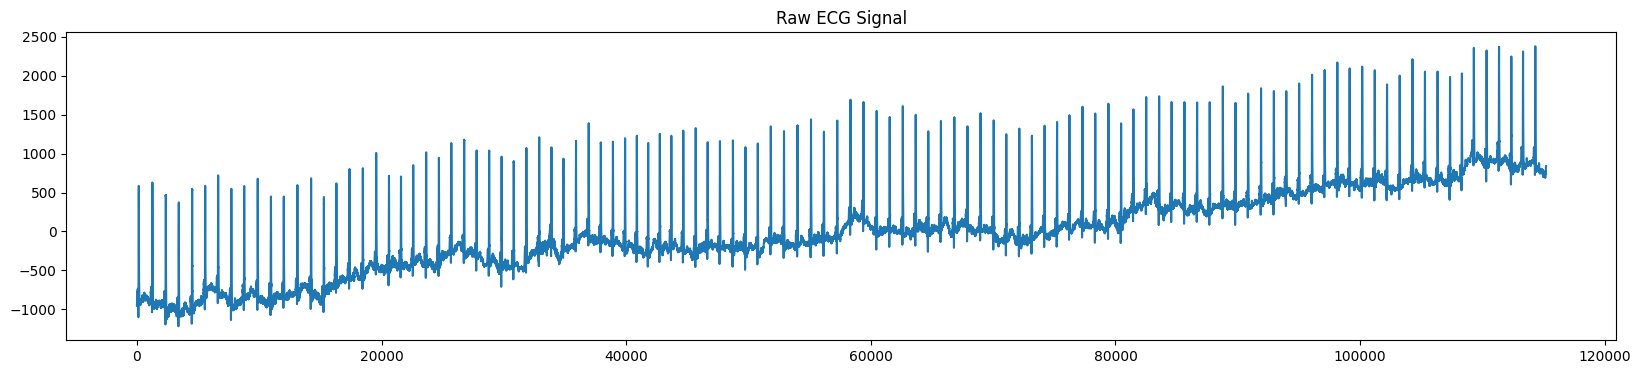

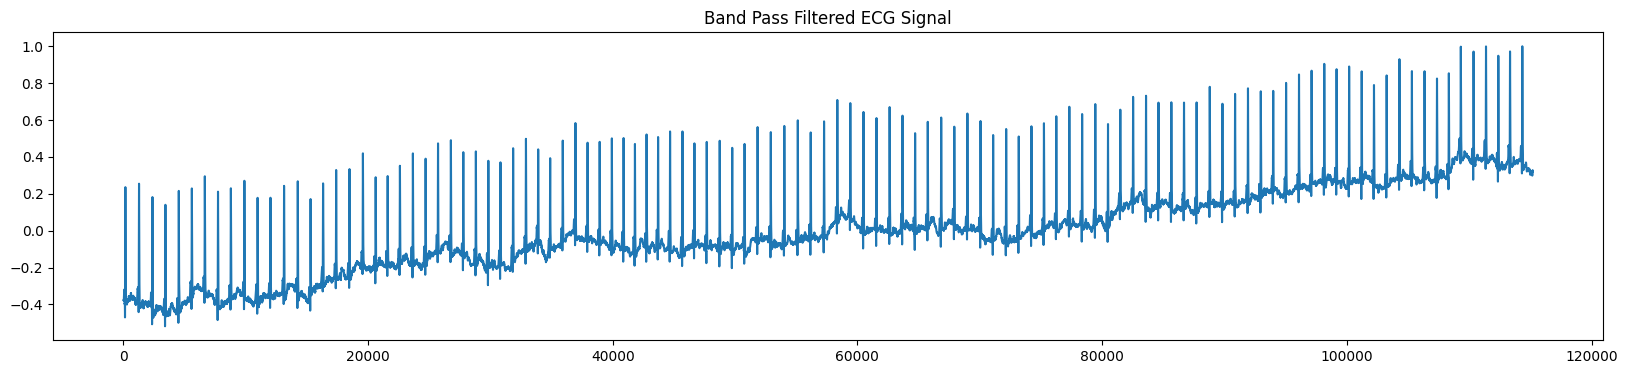

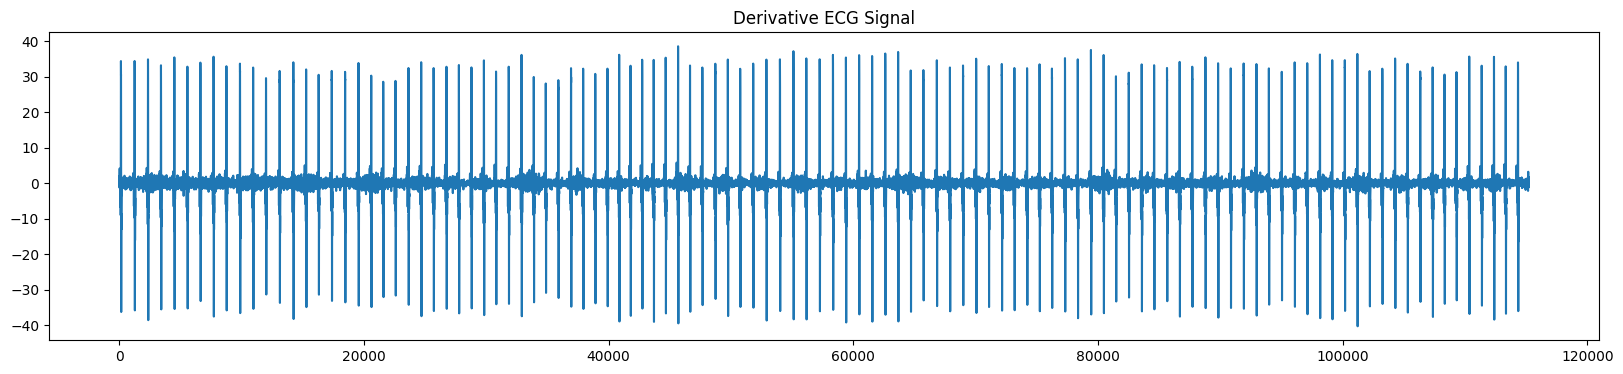

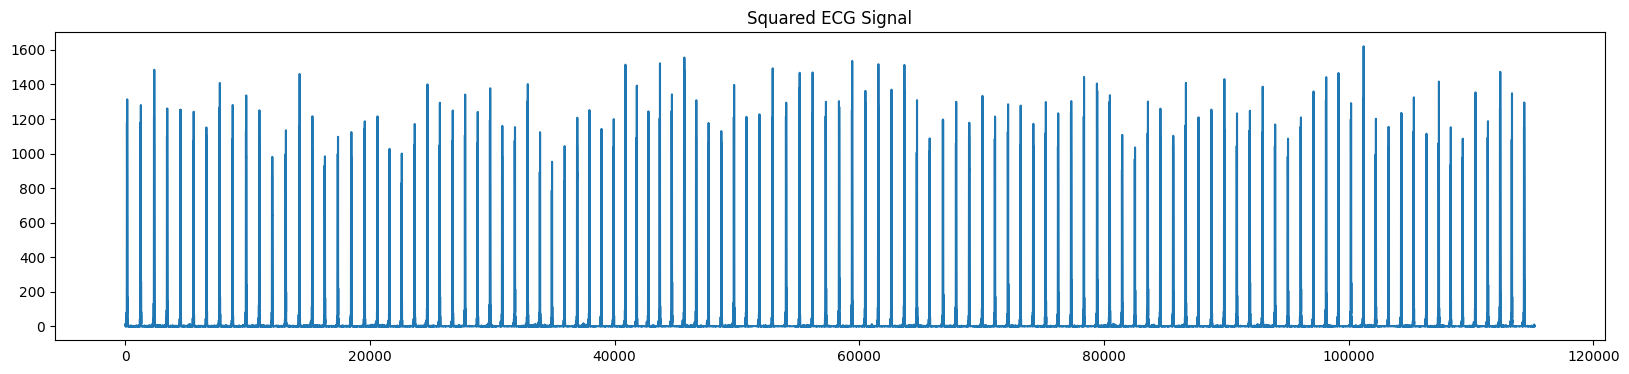

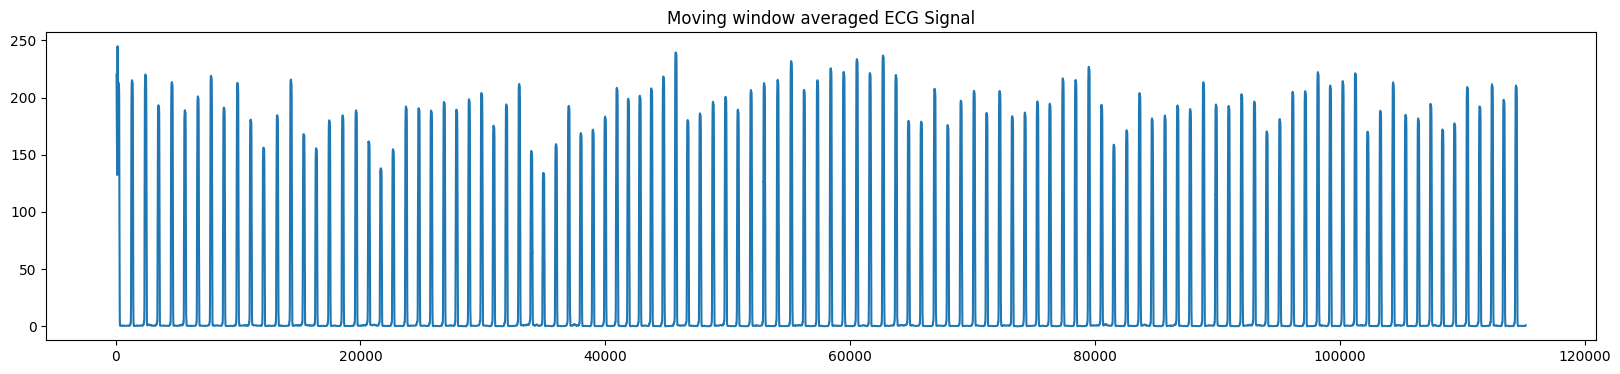

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0393lre', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0393lre', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient133/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient133/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['DYS/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

  3%|▎         | 3/111 [00:00<00:03, 28.40it/s]

img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_1.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_2.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_3.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



  5%|▌         | 6/111 [00:00<00:04, 22.96it/s]

img writtten Images_DATABASE/DYS/fig_93lre_4.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_5.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_6.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_7.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 11%|█         | 12/111 [00:00<00:05, 19.59it/s]

img writtten Images_DATABASE/DYS/fig_93lre_8.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_9.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_10.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_11.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 14%|█▎        | 15/111 [00:00<00:04, 19.39it/s]

img writtten Images_DATABASE/DYS/fig_93lre_12.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_13.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_14.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_15.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 17%|█▋        | 19/111 [00:00<00:04, 18.99it/s]

img writtten Images_DATABASE/DYS/fig_93lre_16.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_17.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_18.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_19.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_20.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 23%|██▎       | 25/111 [00:01<00:03, 21.94it/s]

img writtten Images_DATABASE/DYS/fig_93lre_21.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_22.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_23.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_24.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_25.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 28%|██▊       | 31/111 [00:01<00:03, 23.16it/s]

img writtten Images_DATABASE/DYS/fig_93lre_26.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_27.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_28.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_29.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_30.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 33%|███▎      | 37/111 [00:02<00:08,  9.22it/s]

img writtten Images_DATABASE/DYS/fig_93lre_31.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_32.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_33.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_34.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_35.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_36.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 39%|███▊      | 43/111 [00:02<00:04, 13.90it/s]

img writtten Images_DATABASE/DYS/fig_93lre_37.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_38.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_39.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_40.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_41.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_42.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 44%|████▍     | 49/111 [00:03<00:03, 18.28it/s]

img writtten Images_DATABASE/DYS/fig_93lre_43.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_44.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_45.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_46.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_47.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_48.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 50%|████▉     | 55/111 [00:03<00:02, 22.12it/s]

img writtten Images_DATABASE/DYS/fig_93lre_49.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_50.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_51.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_52.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_53.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_54.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 55%|█████▍    | 61/111 [00:03<00:02, 24.27it/s]

img writtten Images_DATABASE/DYS/fig_93lre_55.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_56.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_57.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_58.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_59.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_60.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 60%|██████    | 67/111 [00:03<00:01, 24.39it/s]

img writtten Images_DATABASE/DYS/fig_93lre_61.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_62.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_63.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_64.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_65.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_66.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 66%|██████▌   | 73/111 [00:03<00:01, 25.51it/s]

img writtten Images_DATABASE/DYS/fig_93lre_67.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_68.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_69.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_70.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_71.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_72.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 71%|███████   | 79/111 [00:04<00:01, 25.80it/s]

img writtten Images_DATABASE/DYS/fig_93lre_73.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_74.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_75.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_76.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_77.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_78.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 77%|███████▋  | 85/111 [00:04<00:01, 25.70it/s]

img writtten Images_DATABASE/DYS/fig_93lre_79.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_80.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_81.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_82.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_83.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_84.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 79%|███████▉  | 88/111 [00:04<00:00, 25.82it/s]

img writtten Images_DATABASE/DYS/fig_93lre_85.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_86.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_87.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_88.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 85%|████████▍ | 94/111 [00:05<00:01, 14.23it/s]

img writtten Images_DATABASE/DYS/fig_93lre_89.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_90.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_91.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_92.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_93.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_94.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 90%|█████████ | 100/111 [00:05<00:00, 18.01it/s]

img writtten Images_DATABASE/DYS/fig_93lre_95.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_96.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_97.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_98.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_99.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_100.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



 95%|█████████▌| 106/111 [00:05<00:00, 21.11it/s]

img writtten Images_DATABASE/DYS/fig_93lre_101.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_102.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_103.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_104.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_105.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_106.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre



100%|██████████| 1/1 [00:05<00:00,  5.96s/it]

img writtten Images_DATABASE/DYS/fig_93lre_107.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_108.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img writtten Images_DATABASE/DYS/fig_93lre_109.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient133/s0393lre


# **Heart Failure**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient118/s0183_re', sampfrom = 0, sampto= 38400, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



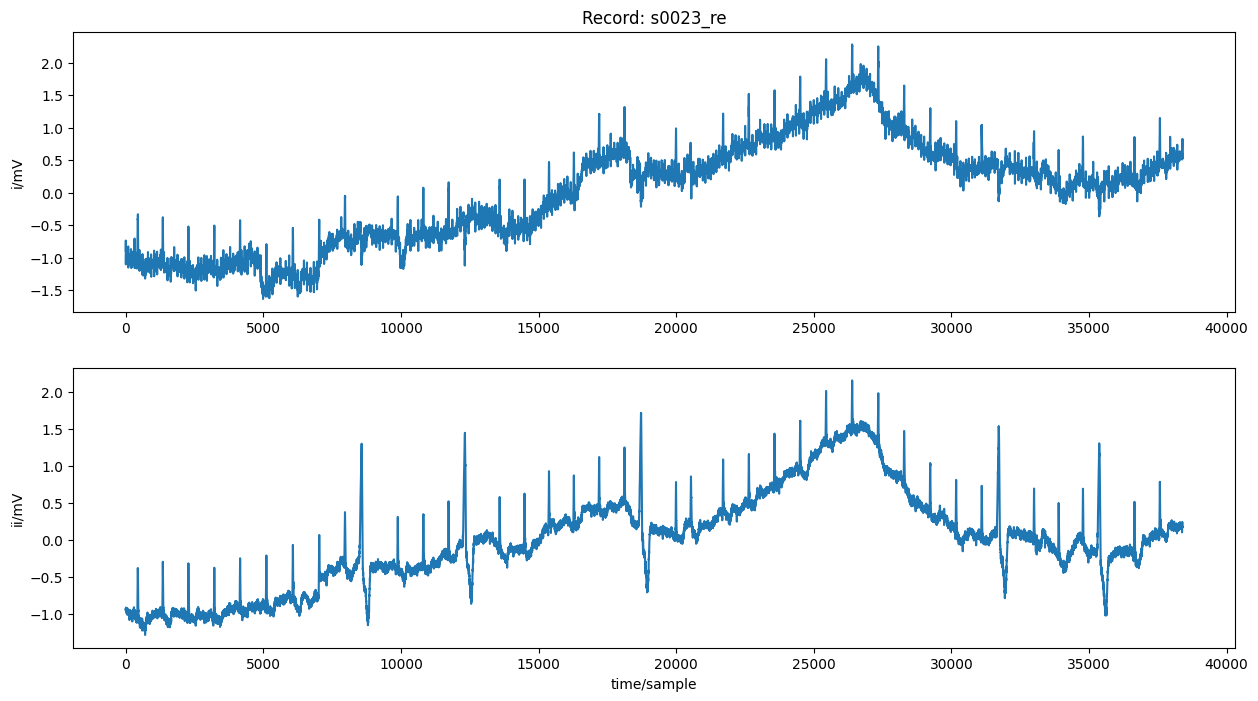

In [ ]:
wfdb.plot_wfdb(record=record, figsize=(15,8))


In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

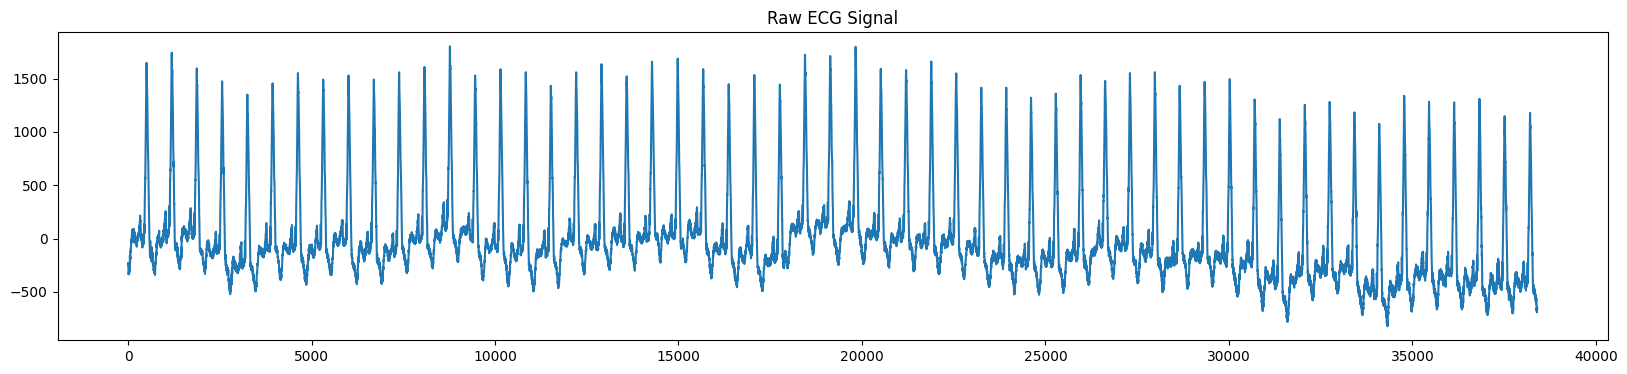

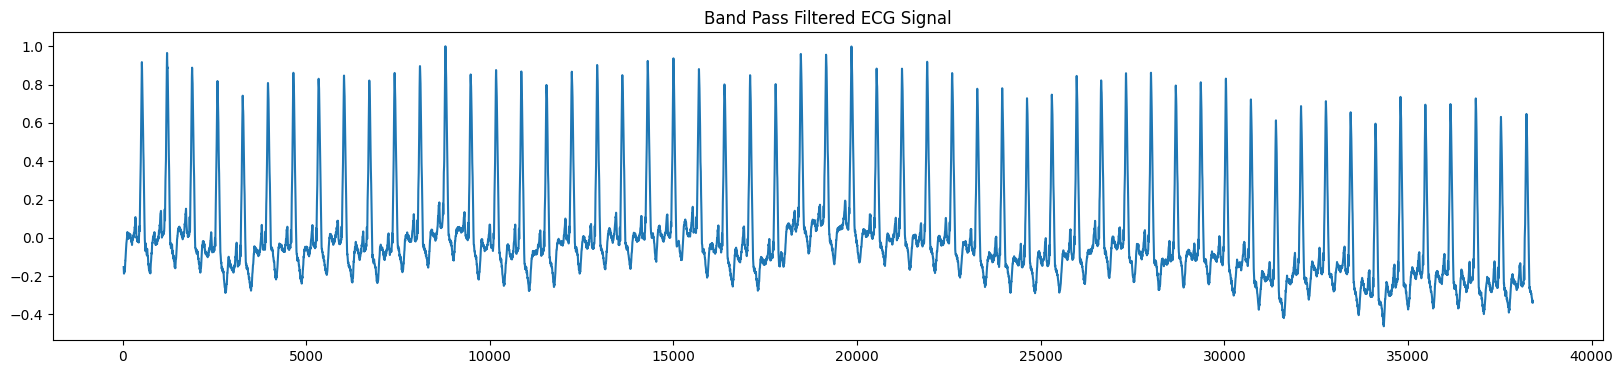

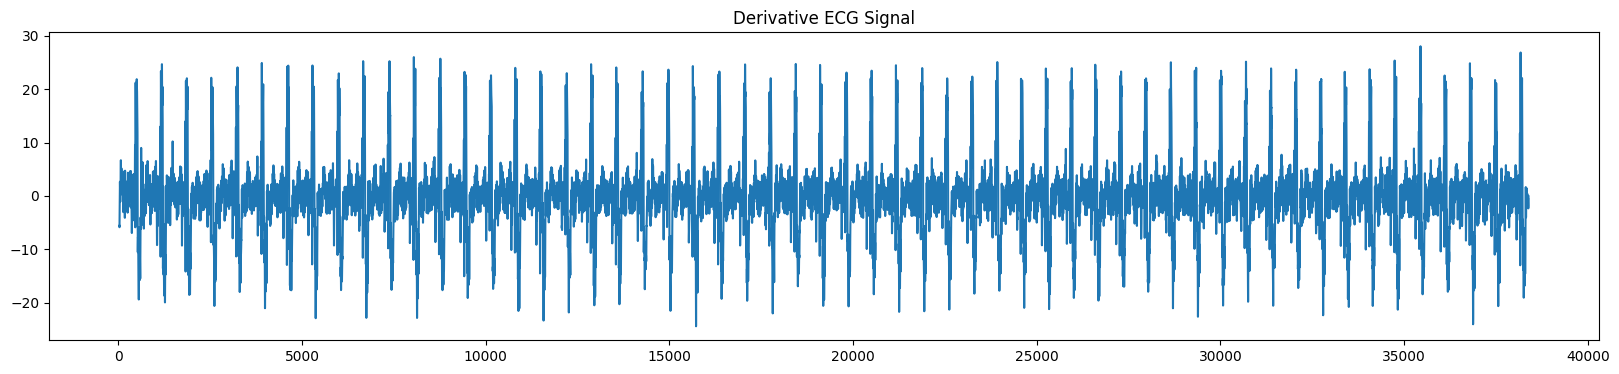

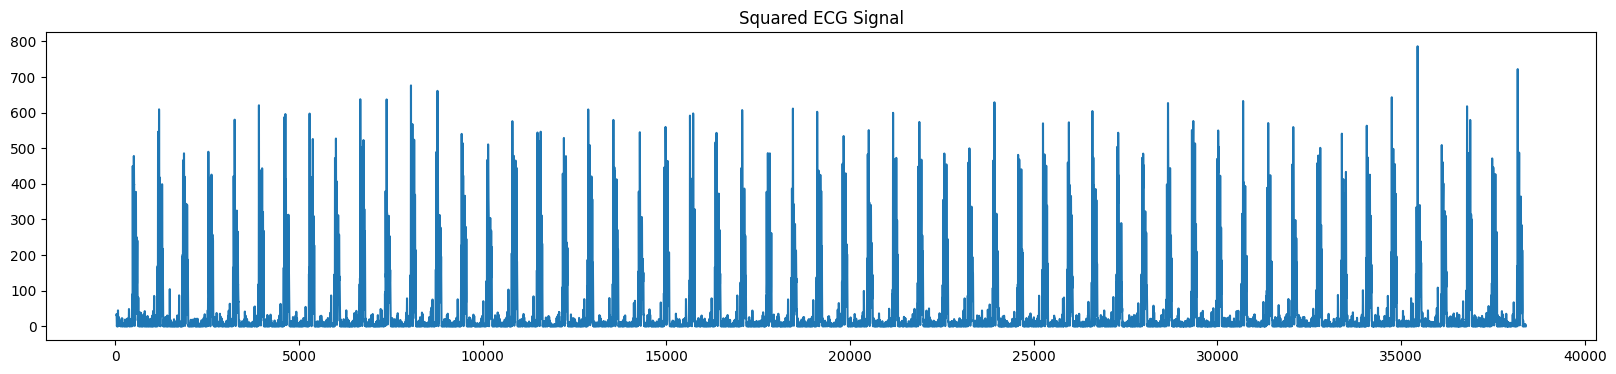

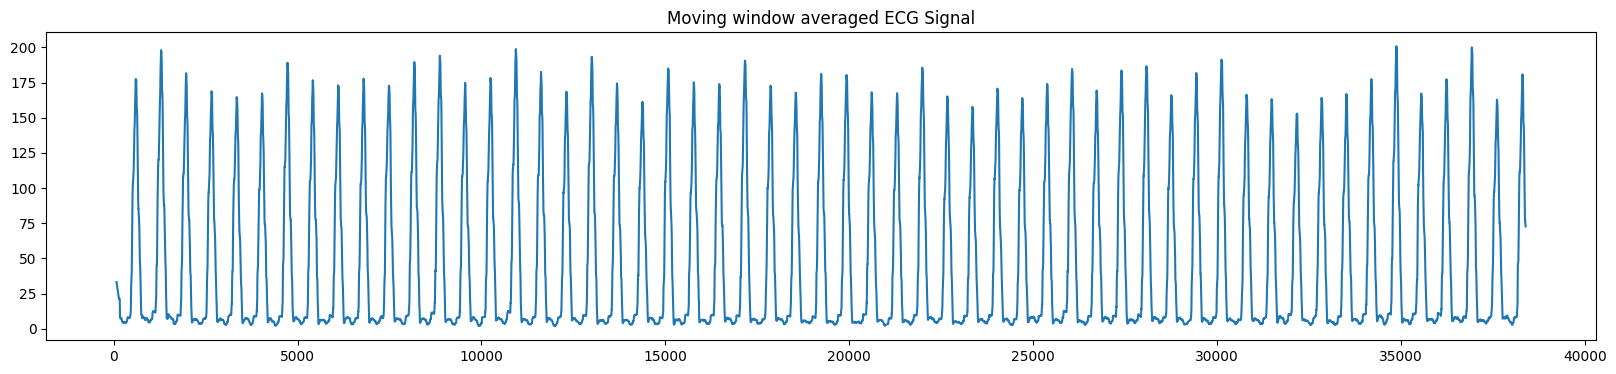

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0183_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0183_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient118/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient118/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient118/s0183_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['HF/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

# **Palpilation**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient126/s0154_re', sampfrom = 0, sampto= 38400, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

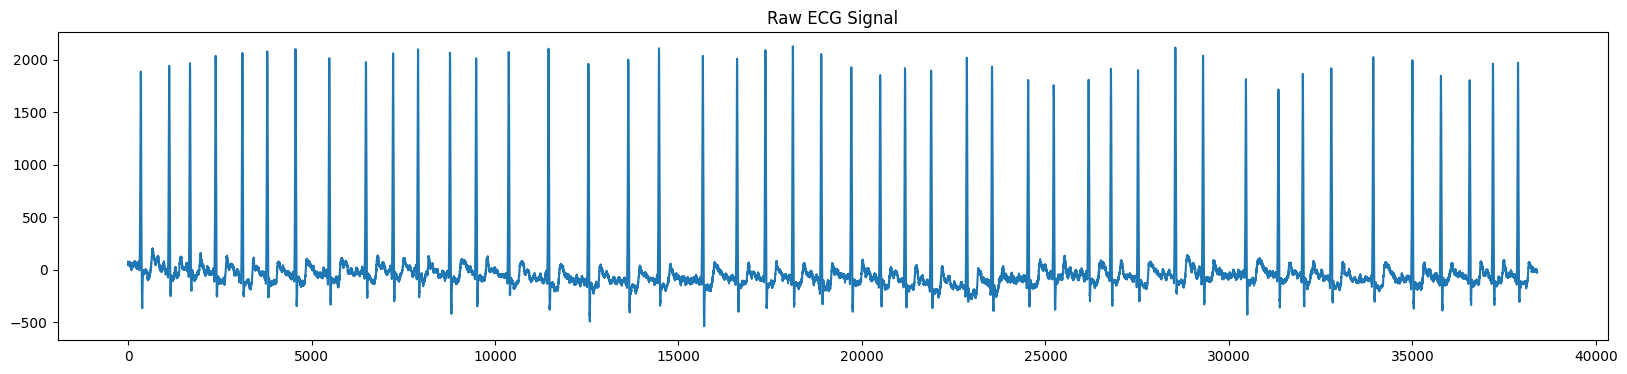

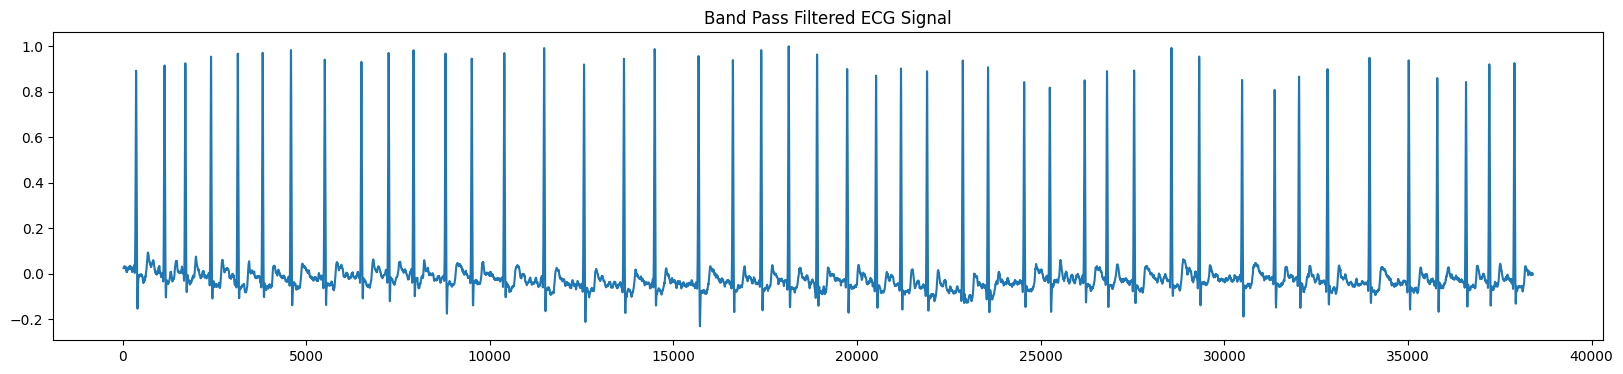

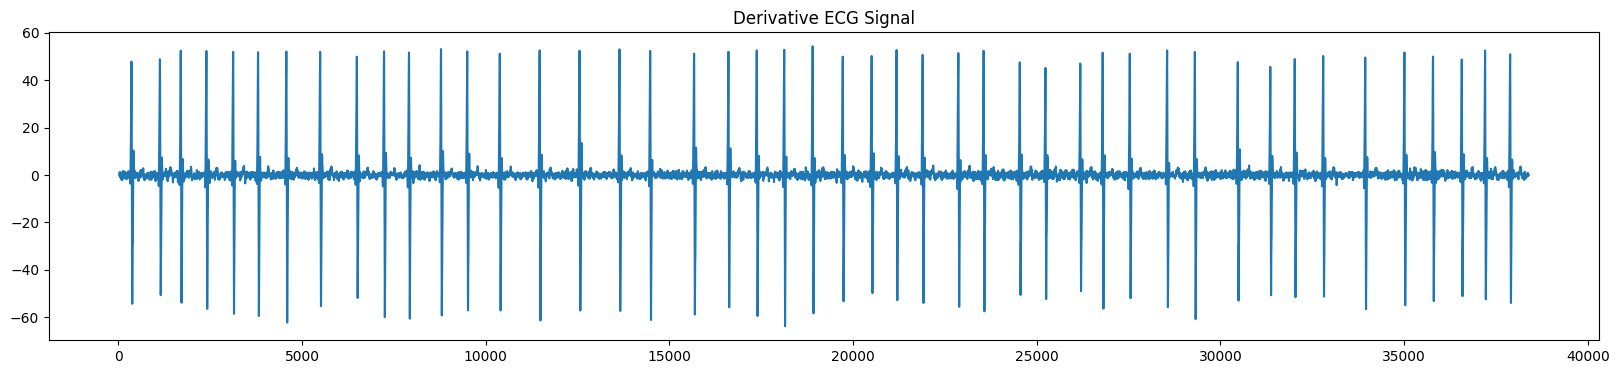

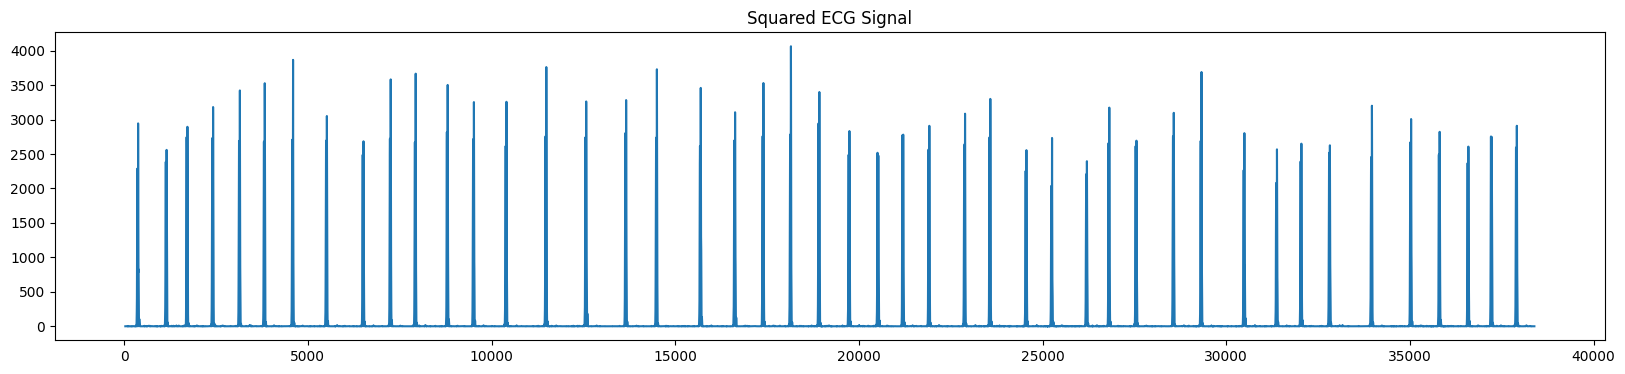

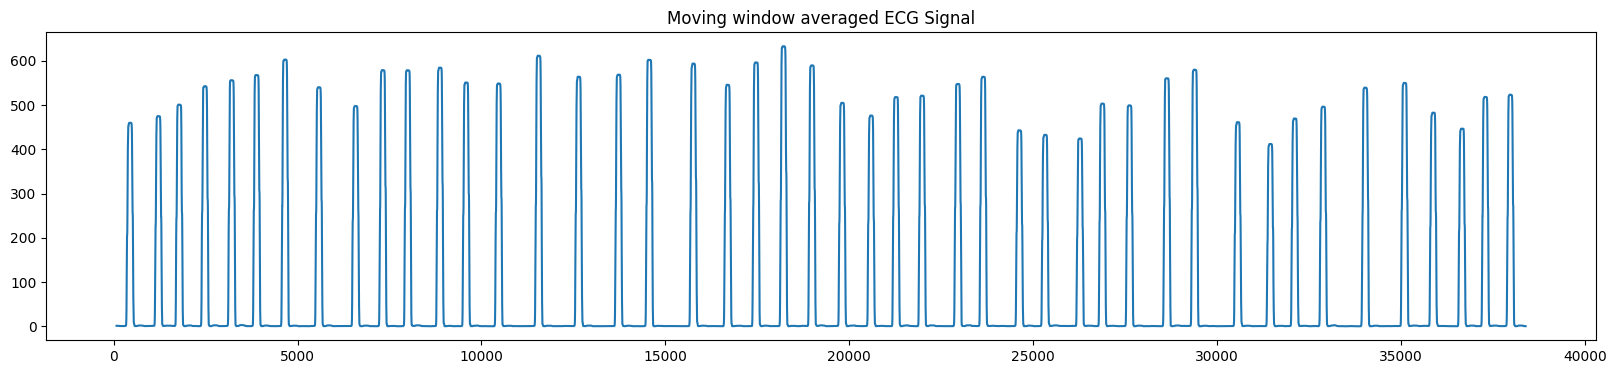

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0154_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0154_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient126/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient126/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient126/s0154_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['PAL/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

# **Cardiomyopathy**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient215/s0437_re', sampfrom = 0, sampto= 120012, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

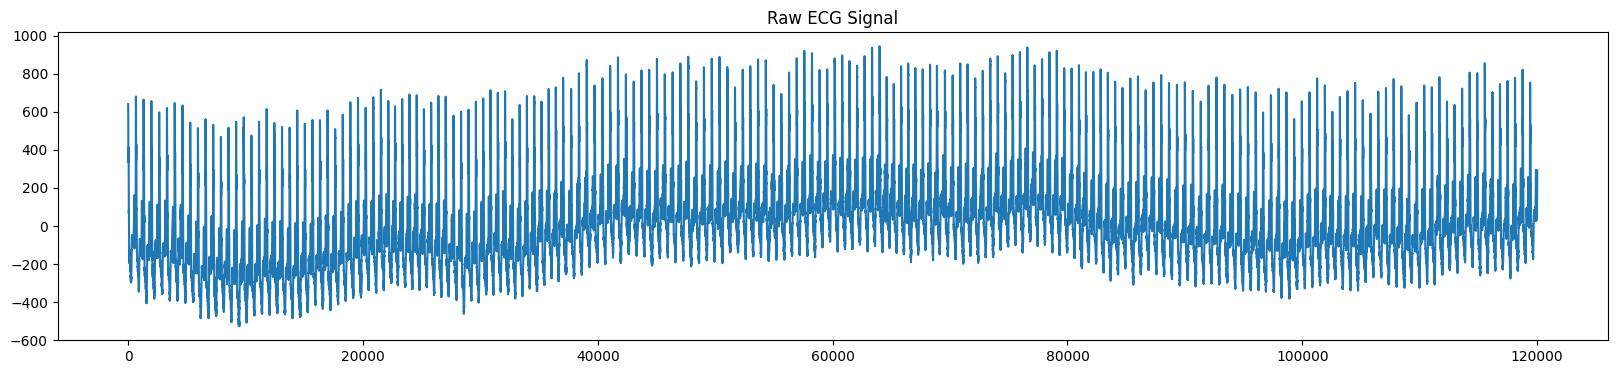

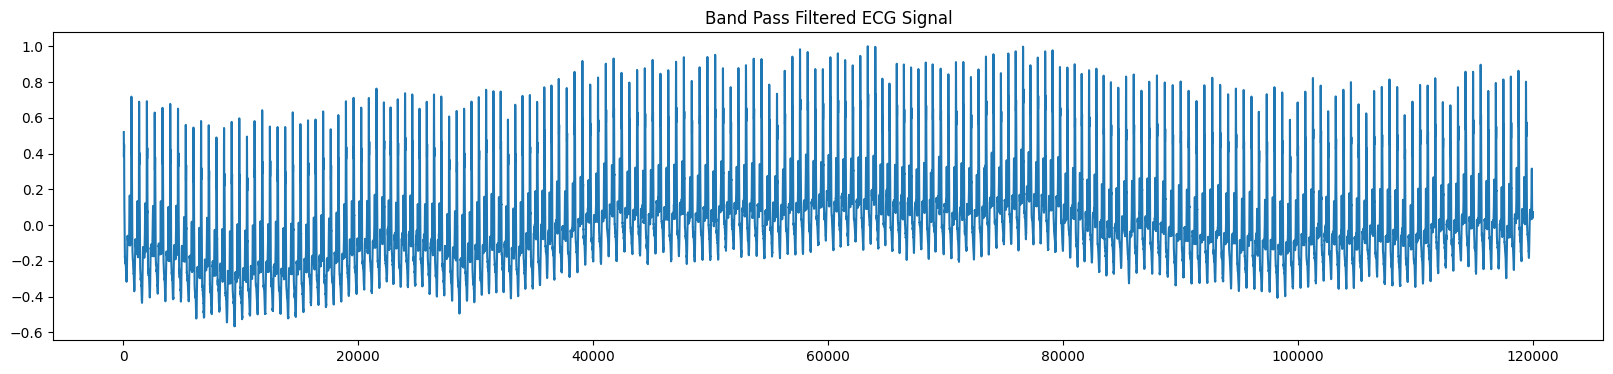

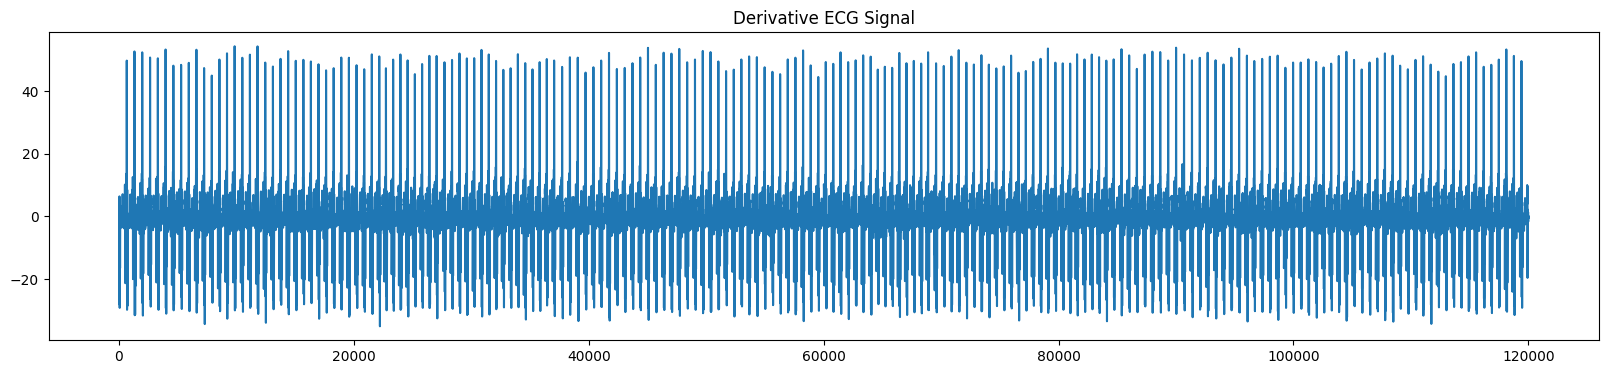

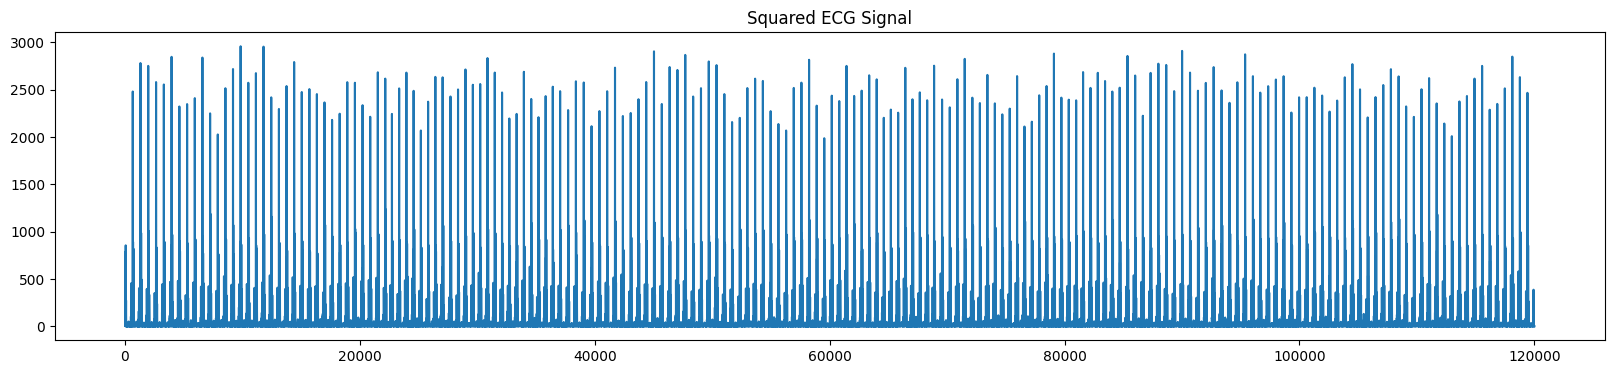

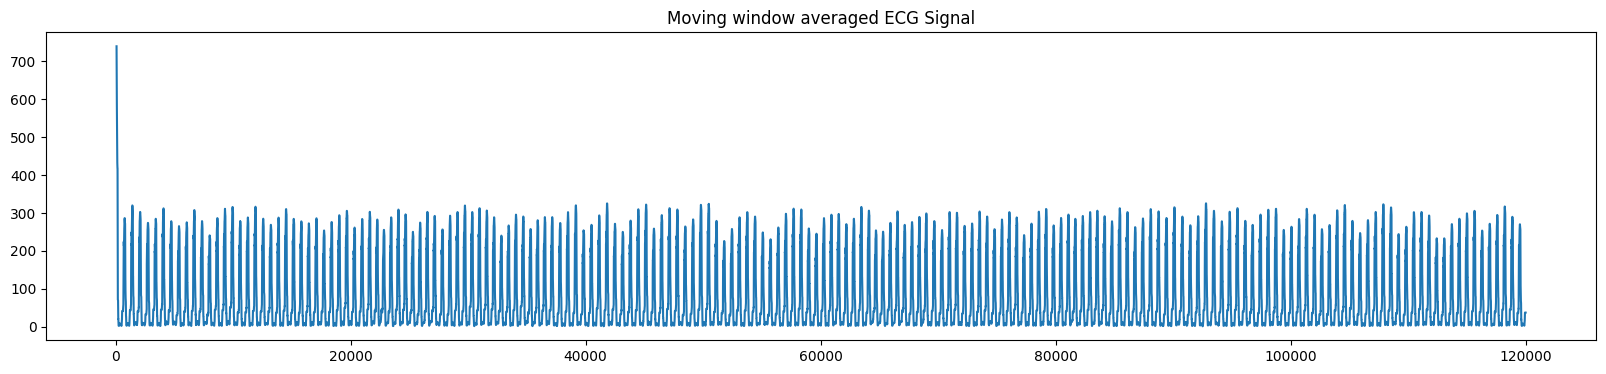

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0437_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0437_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient215/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient215/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient215/s0437_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['CMO/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

# **Stable Angina**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre', sampfrom = 0, sampto= 38400, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

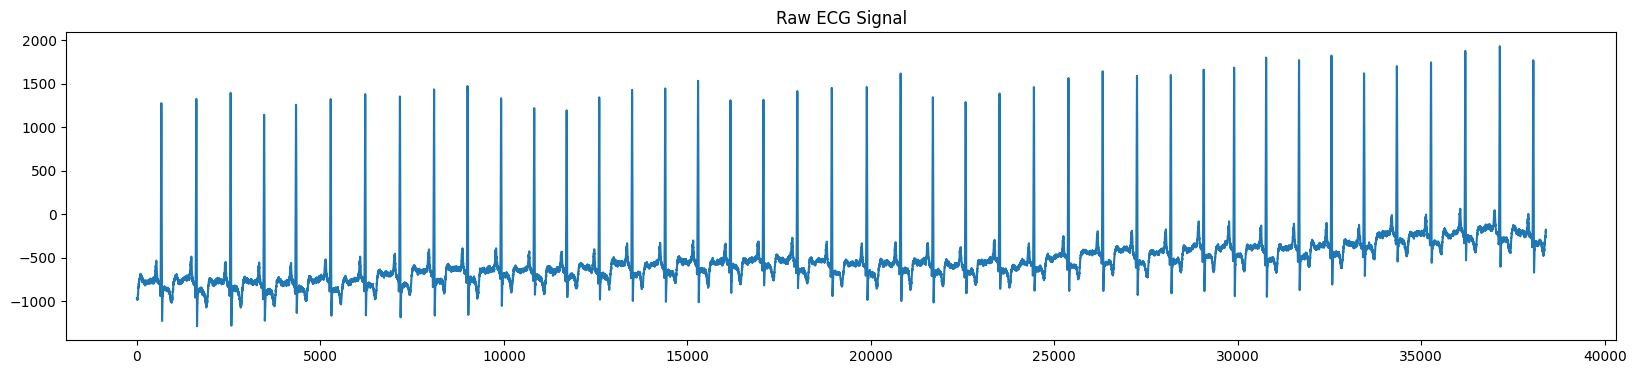

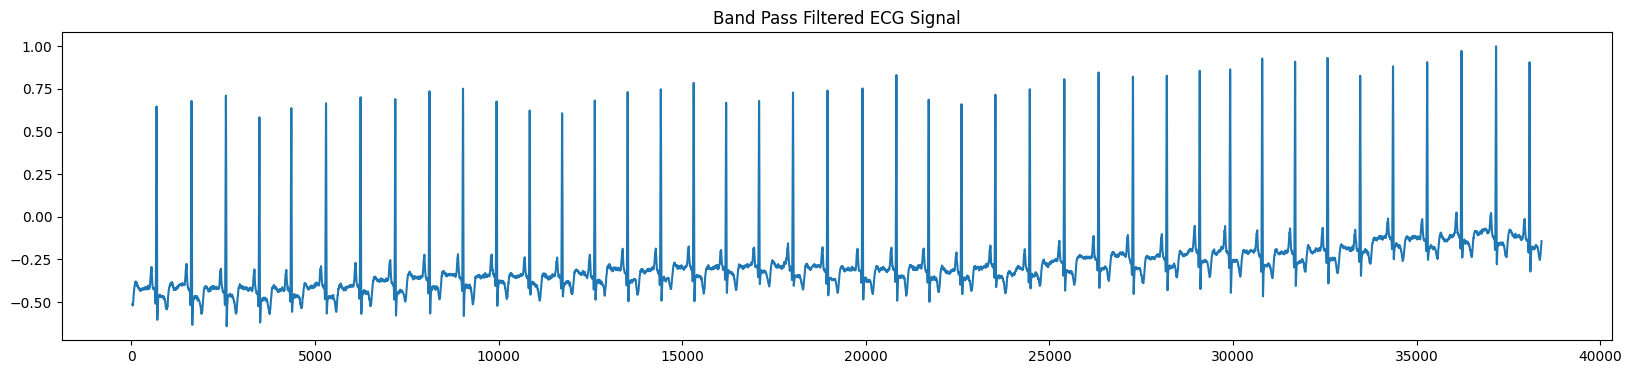

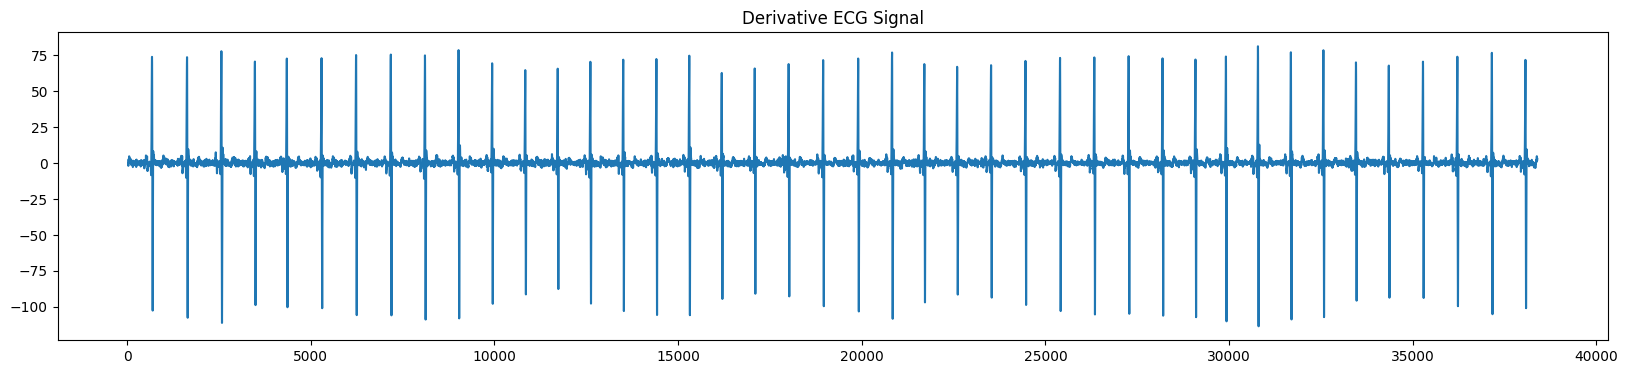

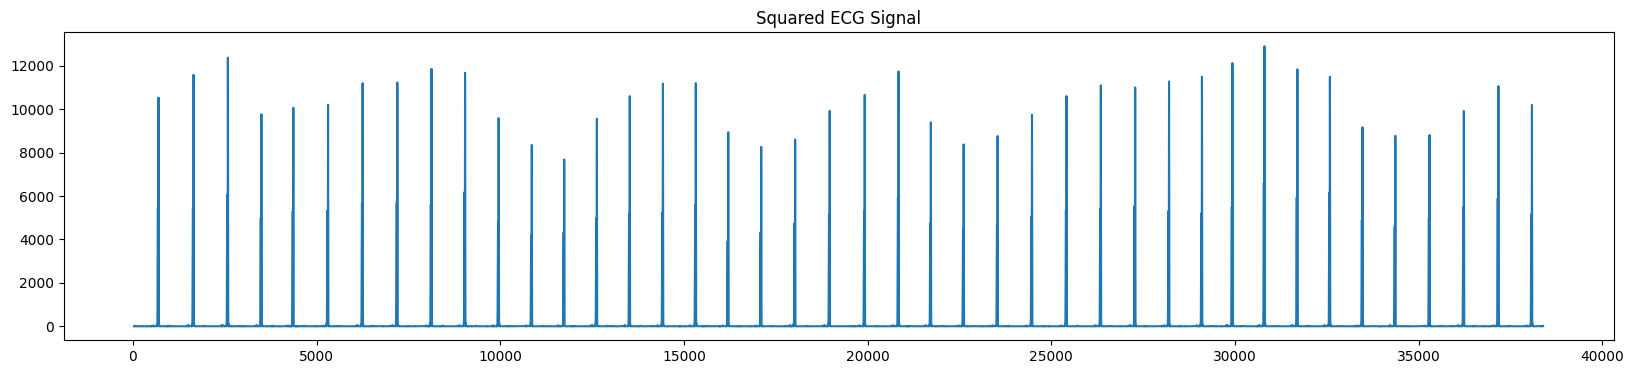

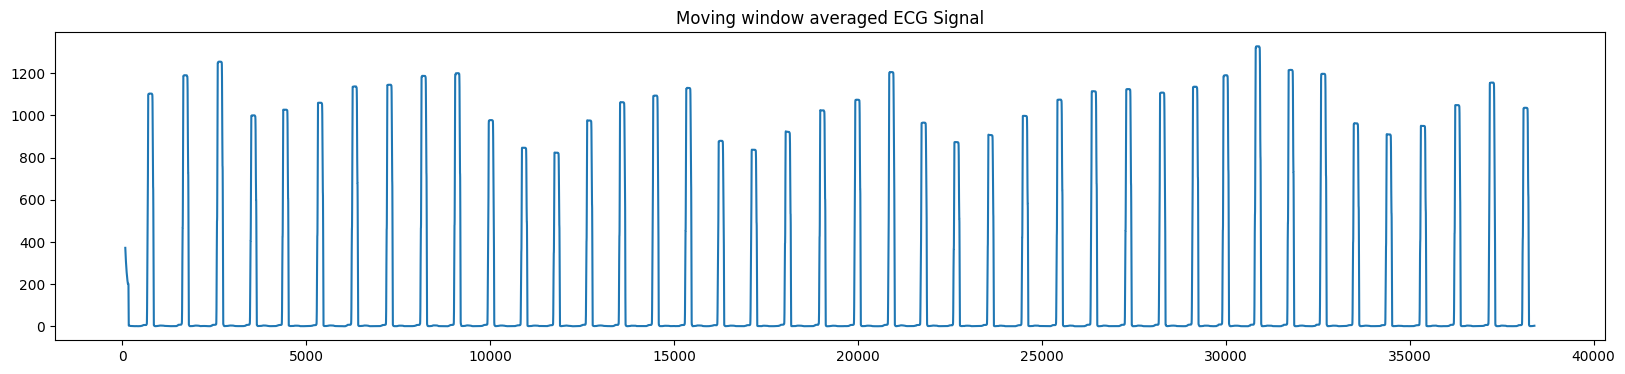

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0340lre', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0340lre', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient191/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient191/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['STA/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

 10%|▉         | 4/42 [00:00<00:01, 36.07it/s]

img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_1.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_2.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_3.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_4.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_5.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre



 29%|██▊       | 12/42 [00:00<00:01, 28.92it/s]

img writtten Images_DATABASE/STA/fig_40lre_6.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_7.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_8.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_9.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_10.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_11.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre



 43%|████▎     | 18/42 [00:00<00:00, 26.80it/s]

img writtten Images_DATABASE/STA/fig_40lre_12.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_13.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_14.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_15.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_16.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_17.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre



 57%|█████▋    | 24/42 [00:00<00:00, 25.34it/s]

img writtten Images_DATABASE/STA/fig_40lre_18.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_19.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_20.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_21.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_22.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_23.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre



 71%|███████▏  | 30/42 [00:01<00:00, 24.72it/s]

img writtten Images_DATABASE/STA/fig_40lre_24.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_25.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_26.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_27.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_28.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_29.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre



 86%|████████▌ | 36/42 [00:01<00:00, 24.92it/s]

img writtten Images_DATABASE/STA/fig_40lre_30.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_31.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_32.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_33.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_34.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_35.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre



100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

img writtten Images_DATABASE/STA/fig_40lre_36.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_37.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_38.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_39.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img writtten Images_DATABASE/STA/fig_40lre_40.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient191/s0340lre


# **Myocardial Hypertrophy**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient210/s0432_re', sampfrom = 0, sampto= 120012, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

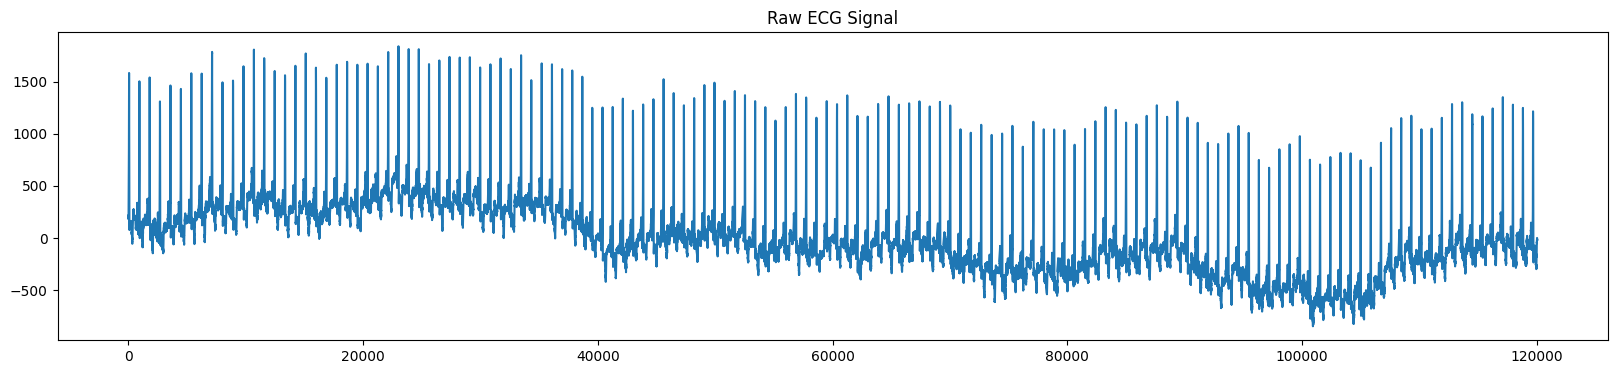

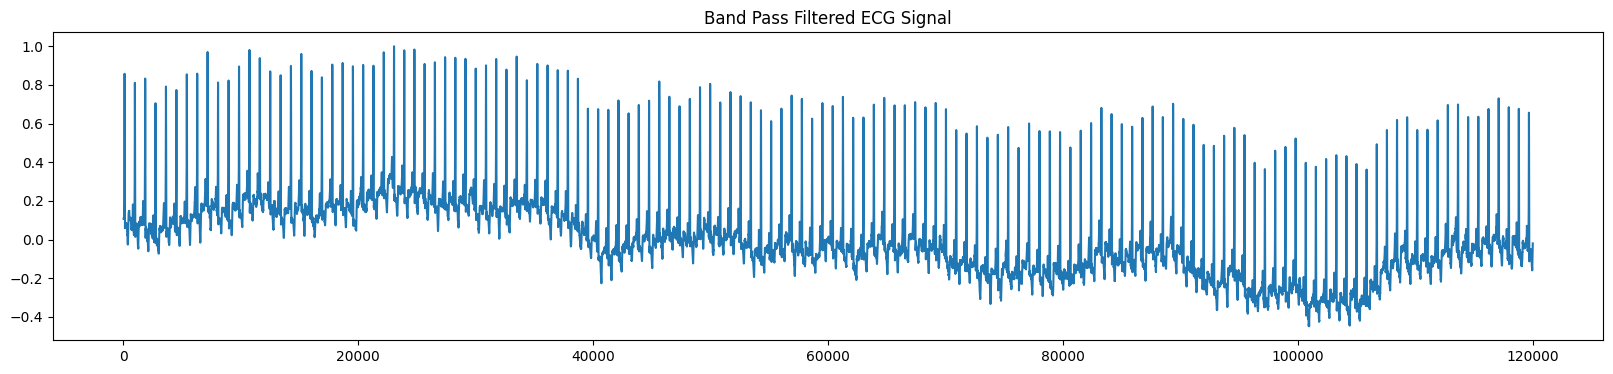

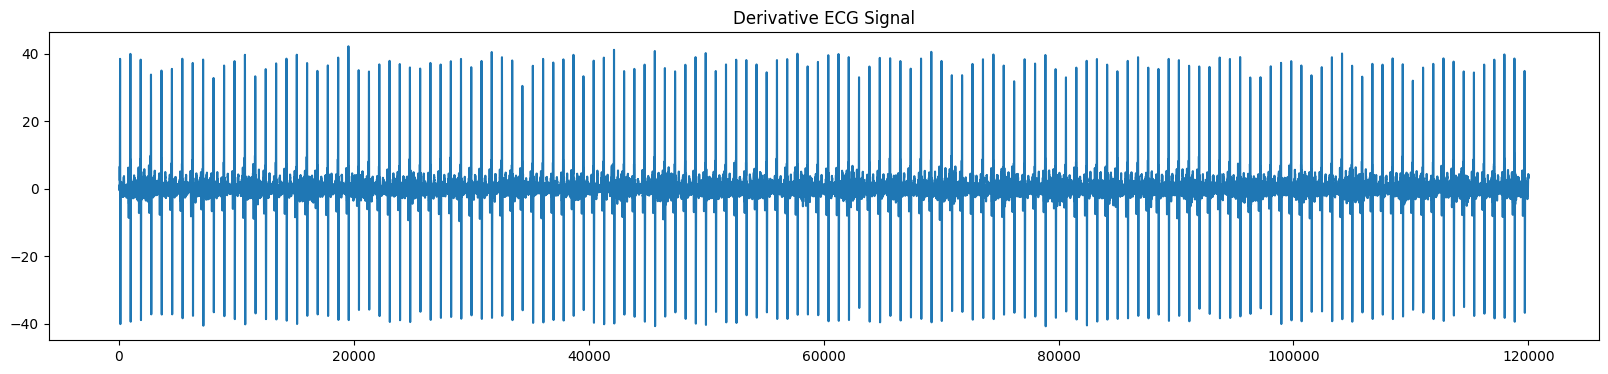

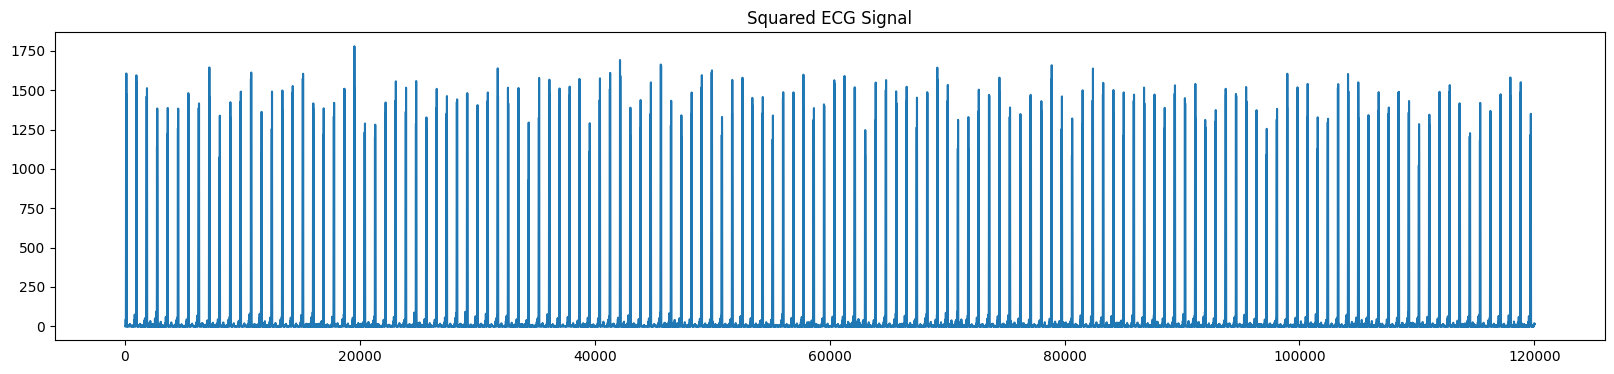

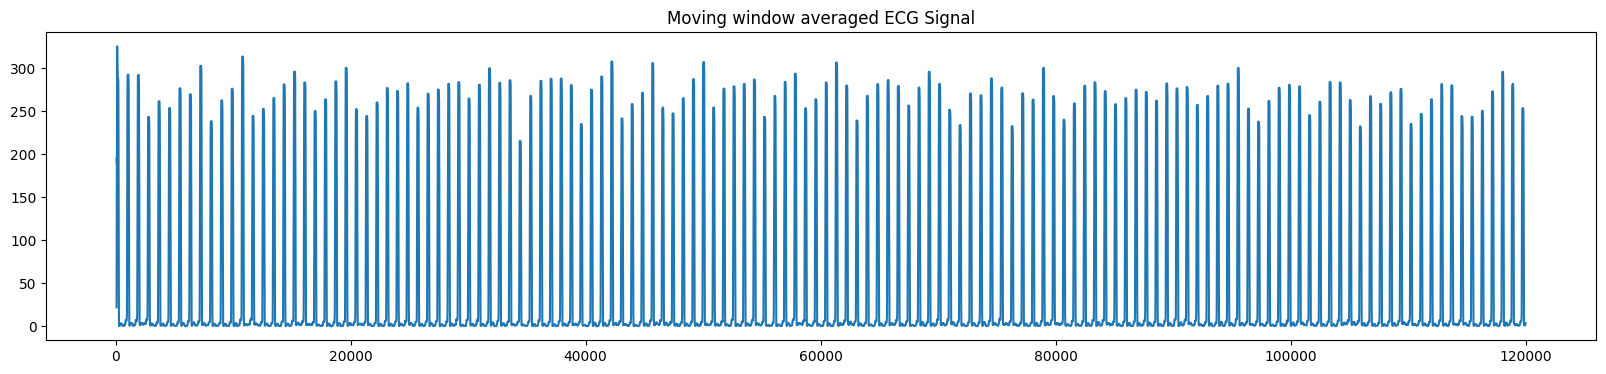

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0432_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0432_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient210/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient210/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient210/s0432_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['MH/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

# **Bundle Branch Block**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient206/s0427_re', sampfrom = 0, sampto= 120012, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

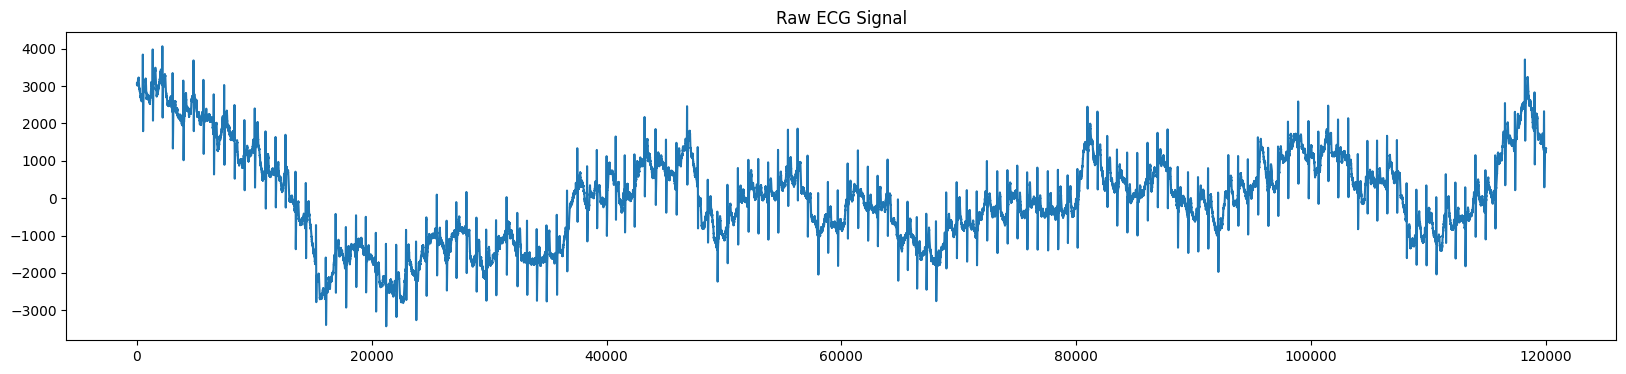

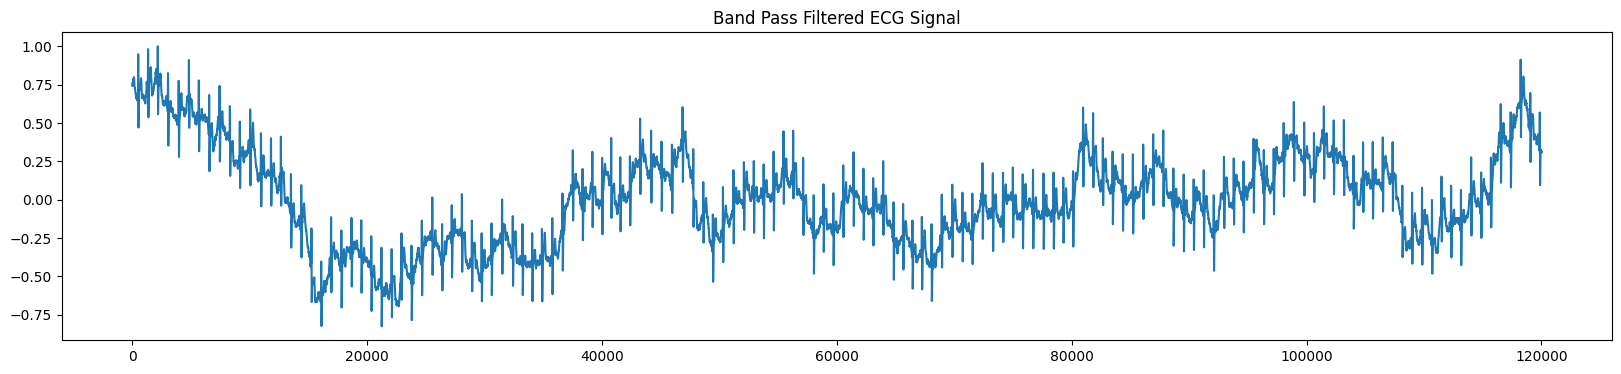

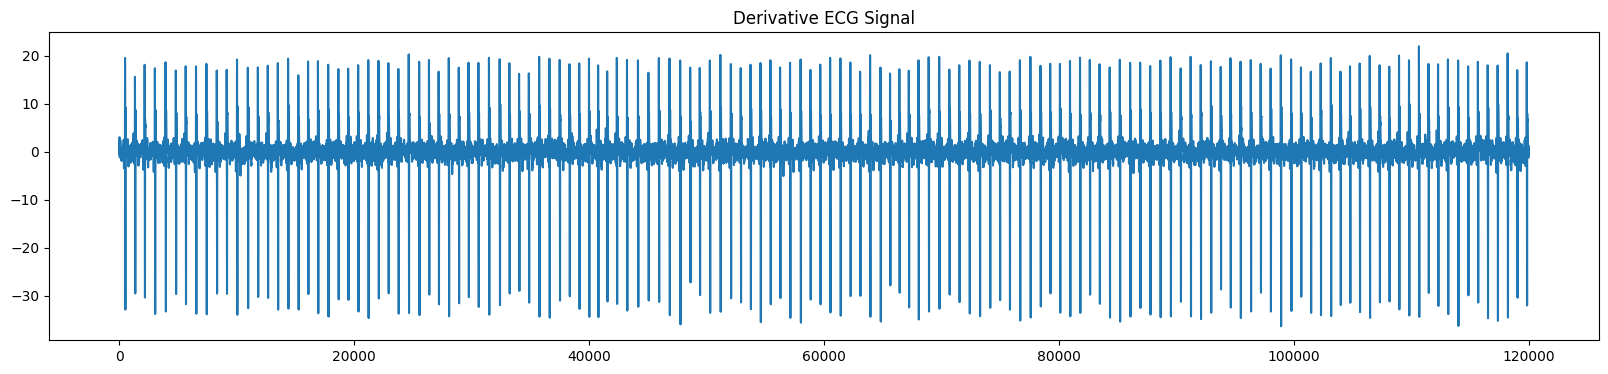

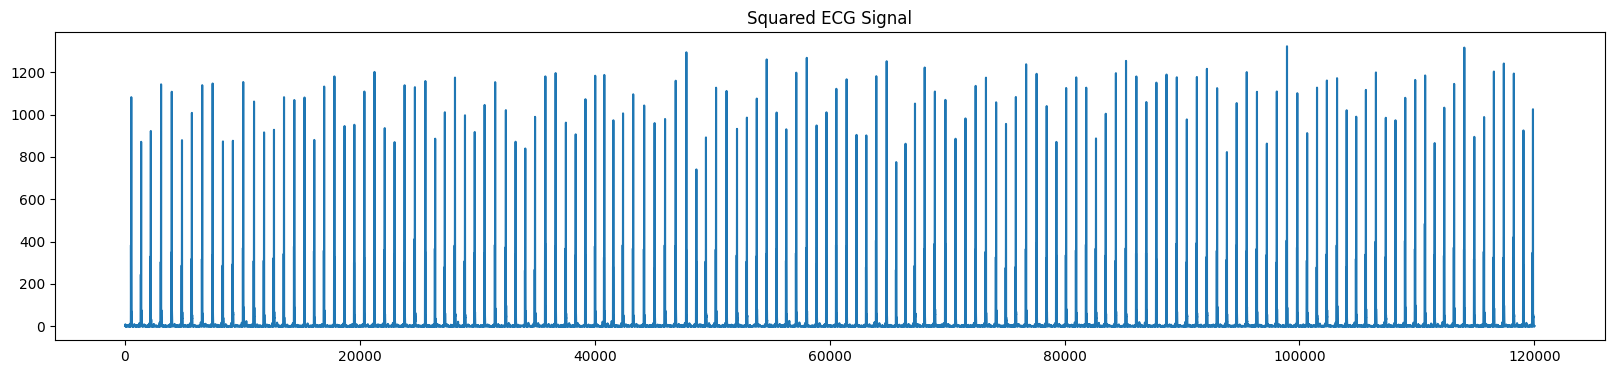

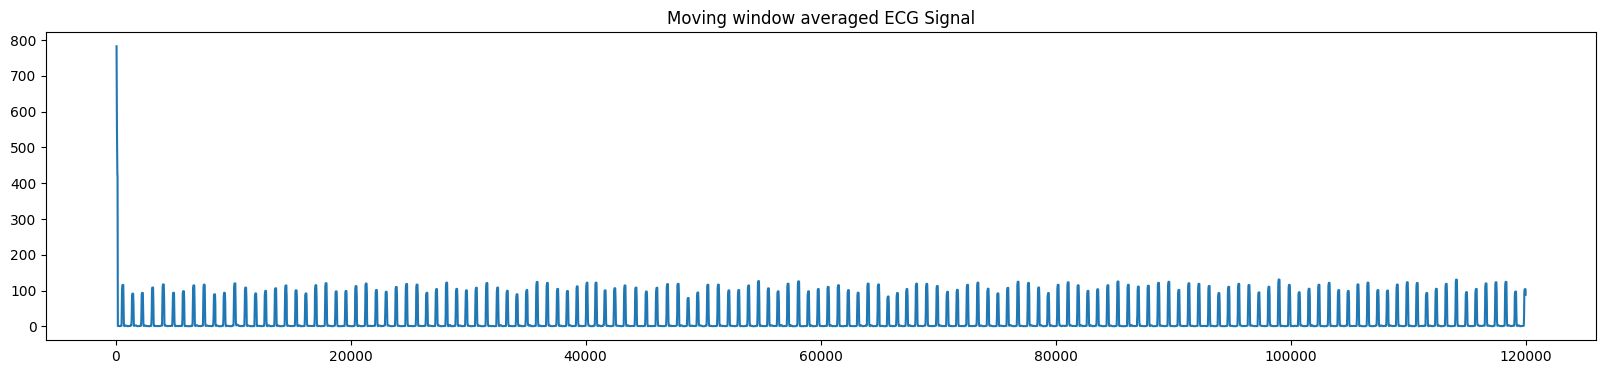

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0427_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0427_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient206/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient206/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient206/s0427_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['BBB/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

# **Unstable Angina**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient196/s0002_re', sampfrom = 0, sampto= 38400, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

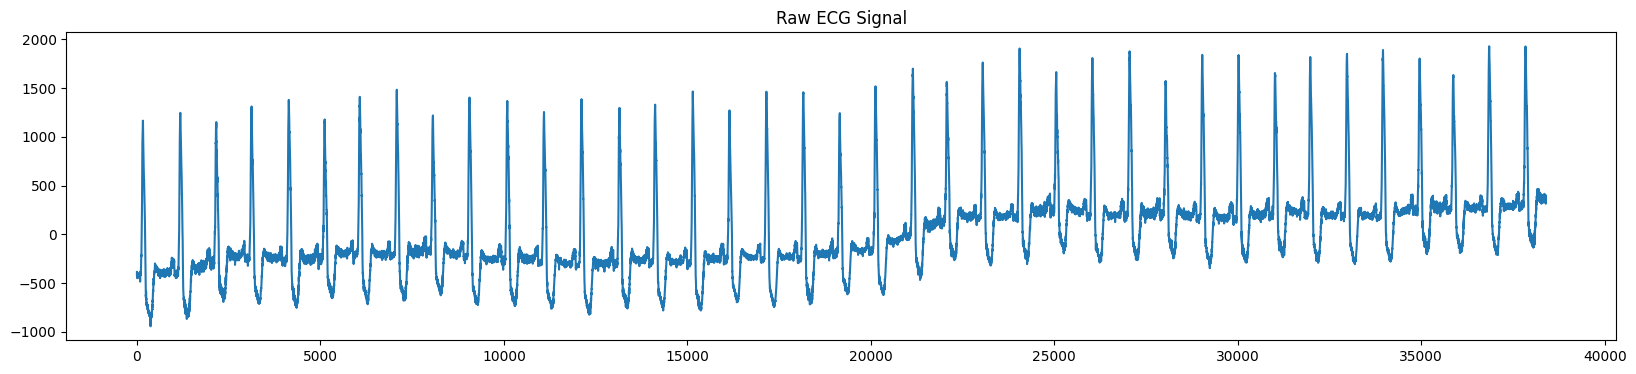

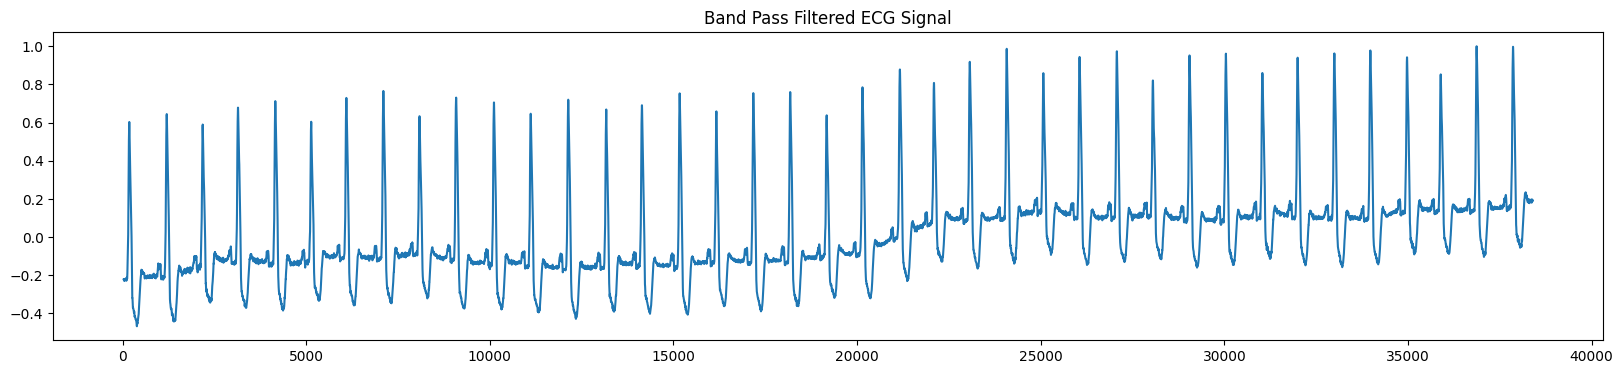

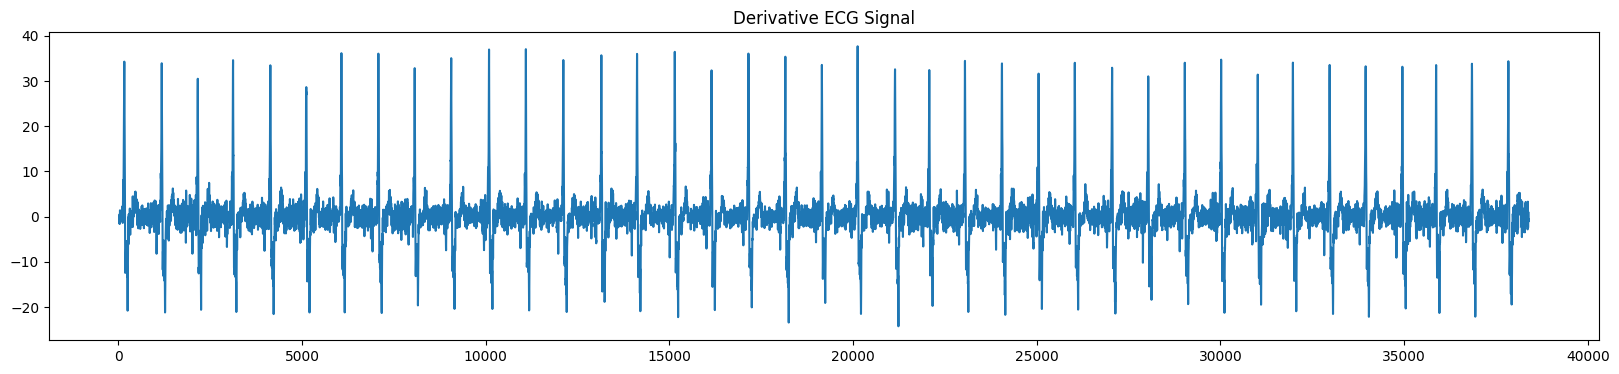

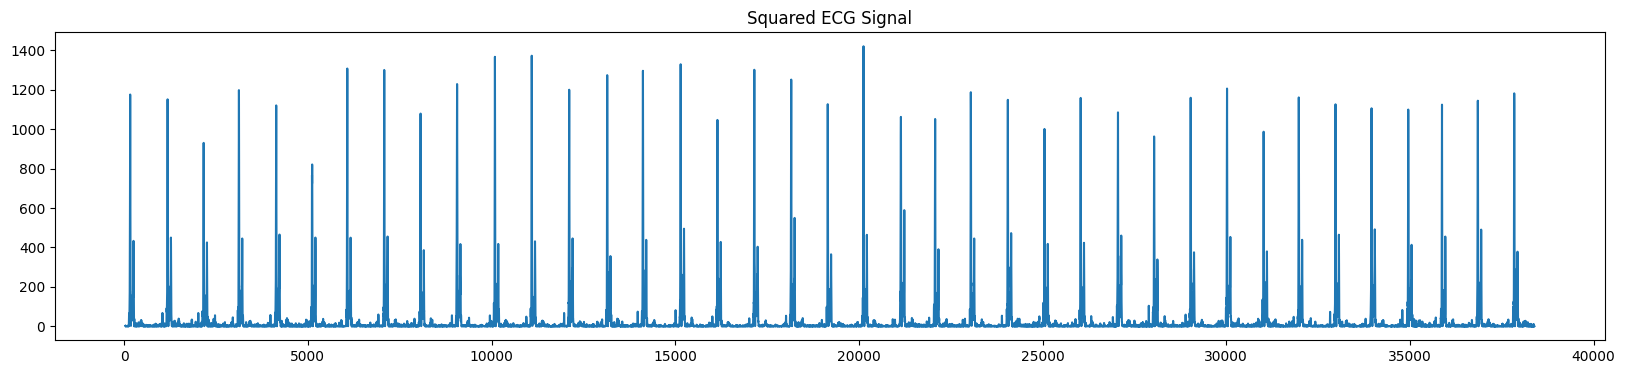

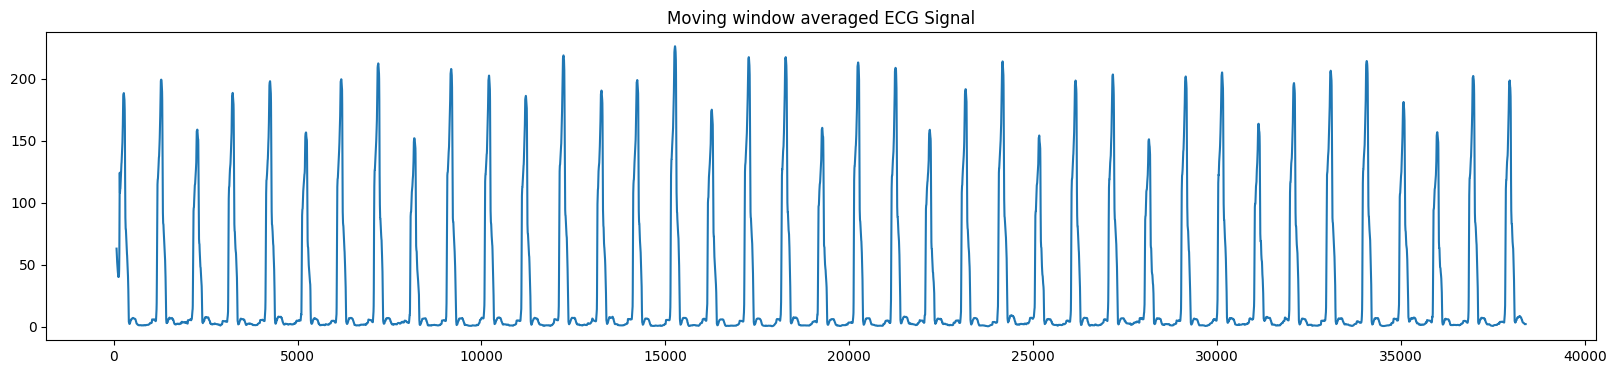

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0002_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0002_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient196/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient196/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient196/s0002_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['USA/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

# **Myocarditis**

In [ ]:
import wfdb
record = wfdb.rdrecord('/content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re', sampfrom = 0, sampto= 120012, channels = [0]) # load the ECG signal
signal = record.p_signal.flatten() # extract the ECG signal as a 1D array\



In [ ]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = record.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

Text(0.5, 1.0, 'Moving window averaged ECG Signal')

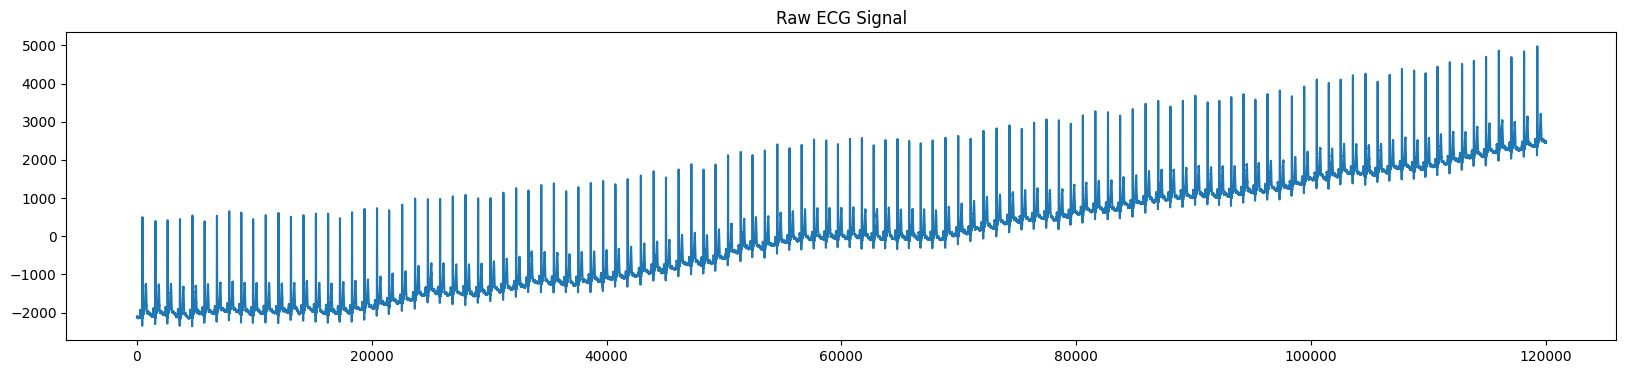

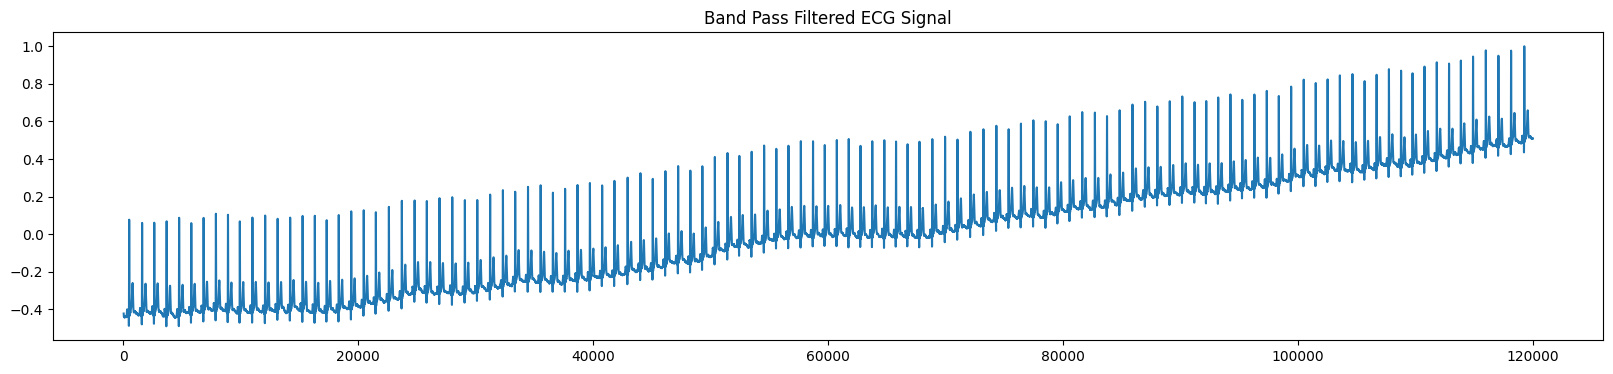

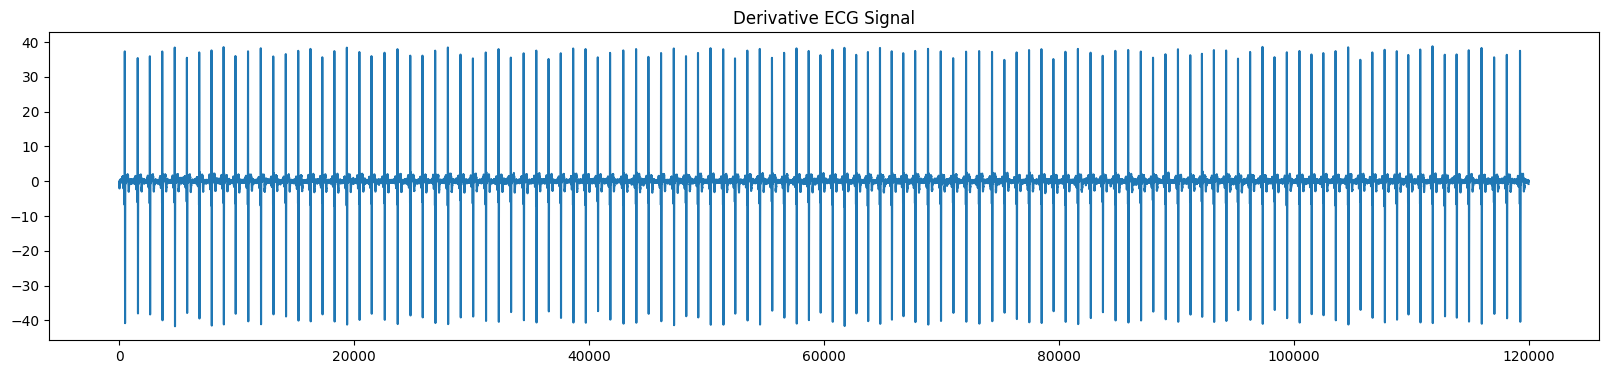

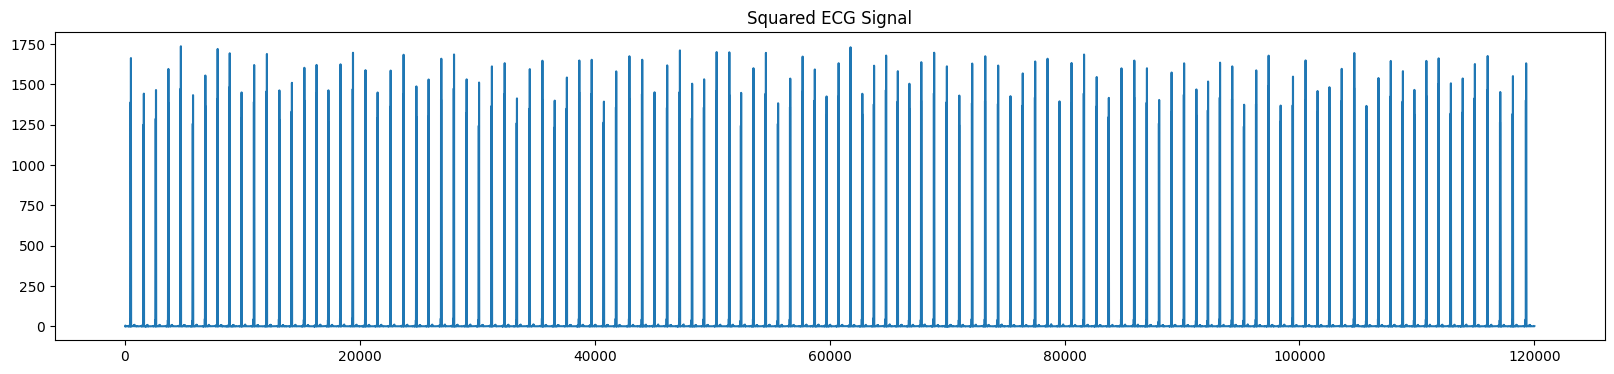

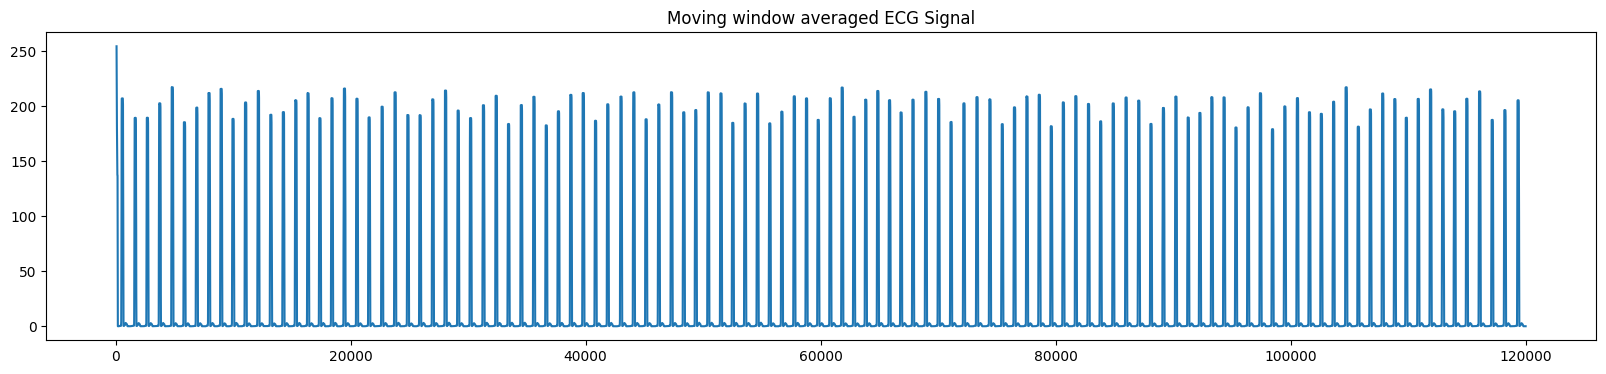

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


In [ ]:
from biosppy.signals import ecg
out = ecg.christov_segmenter(band_pass_signal, sampling_rate=fs)
rpeaks = out['rpeaks'] # extract the R-peak indices


In [ ]:
import wfdb
ann = wfdb.Annotation(record_name='s0484_re', extension='atr', sample=rpeaks, symbol=['N']*len(rpeaks)) # create a new annotation file
wfdb.wrann('s0484_re', 'atr', ann.sample, ann.symbol, write_dir='/content/ptb-diagnostic-ecg-database-1.0.0/patient249/') # write the annotation file to disk


In [ ]:
print(os.getcwd())
def get_records():
    """ Get paths for data in data/mit/ directory """
    #Download if doesn't exist
    # There are 3 files for each record
    # *.atr is one of them
    paths = glob.glob('/content/ptb-diagnostic-ecg-database-1.0.0/patient249/*.atr') # returns an array of path names that matches the arguement
    #paths = [os.path.join(os.getcwd(),path) for path in paths]
    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

records = get_records()
print ('There are {} record files'.format(len(records)))
print (records)

/content
There are 1 record files
['/content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re']


In [ ]:
def beat_annotations(annotation, type):
    
    good = [type] 
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

In [ ]:
import wfdb

def signal_segmentation(sig, type, output_dir=''):
    count = 1
    signals, fields = wfdb.rdsamp(sig, channels = [0])
    ann = wfdb.rdann(sig, 'atr')
    imp_beats = beat_annotations(ann, type)
    beats = (ann.sample)
    for i in tqdm(imp_beats):
        beats = np.array(beats)
        index_i = np.where(beats == i) # find the indexes (location tuples) of all imp_beats(desired annotated beats) inside the array of all beats
        j = index_i[0][0] # as numpy.where returns tuples we only need the first index of item that match
        if(j!=0 and j!=(len(beats)-1)):
            # according to paper
            sig_start = beats[j-1] + 20
            sig_end = beats[j+1] - 20
            data = signals[sig_start:sig_end, 0]
            
            # Plot and save the beat
            fig = plt.figure(dpi=300, frameon=False, figsize=(1.0,0.5))
            plt.plot(data, linewidth=0.5)
            plt.xticks([]), plt.yticks([])
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            filename = output_dir + 'fig_{}_{}'.format(sig[-5:],count) + '.png'  # sig[-3:] is the last 3 characters (mit-bih file number)
            fig.savefig(filename)
            plt.close()
            im_color = cv2.imread(filename, cv2.IMREAD_COLOR)
            im_color = cv2.copyMakeBorder(im_color,75,75,0,0, cv2.BORDER_REPLICATE) # as the image shape (from plt.savefig) is 300px*150px due to figsize=(1.0,0.5) and dpi=300 where dpi means dots(pixels) per inch
            im_color = cv2.resize(im_color, (150, 150), interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(filename, im_color)
            print('img writtten {}'.format(filename))
            count += 1
        print('img completed {}'.format(sig))


In [ ]:
labels = ['N']
output_dirs = ['MYOC/']
for type, output_dir in zip(labels, output_dirs):
    result_dir = 'Images_DATABASE/'+output_dir
    partial_records = records[0:3]  # 43 elememts out of 48 elements iteration due to RAM shortage
    #print(partial_records)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    for r in tqdm(partial_records):
        signal_segmentation(r, type, output_dir=result_dir)

  4%|▎         | 4/114 [00:00<00:02, 39.33it/s]

img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_1.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_2.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_3.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_4.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_5.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 11%|█         | 12/114 [00:00<00:03, 27.82it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_6.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_7.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_8.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_9.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_10.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_11.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 13%|█▎        | 15/114 [00:00<00:03, 26.33it/s]


img writtten Images_DATABASE/MYOC/fig_84_re_12.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_13.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_14.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_15.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_16.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_17.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re


 18%|█▊        | 21/114 [00:00<00:04, 21.14it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_18.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_19.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_20.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_21.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 21%|██        | 24/114 [00:01<00:05, 15.95it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_22.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_23.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_24.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 25%|██▍       | 28/114 [00:01<00:05, 15.19it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_25.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_26.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_27.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 26%|██▋       | 30/114 [00:01<00:06, 13.21it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_28.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_29.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_30.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 30%|██▉       | 34/114 [00:02<00:06, 12.12it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_31.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_32.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_33.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 33%|███▎      | 38/114 [00:02<00:05, 13.55it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_34.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_35.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_36.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_37.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 35%|███▌      | 40/114 [00:02<00:06, 11.97it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_38.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_39.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 37%|███▋      | 42/114 [00:02<00:06, 10.46it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_40.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_41.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_42.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 39%|███▊      | 44/114 [00:03<00:07,  9.37it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_43.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_44.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 41%|████      | 47/114 [00:03<00:08,  8.35it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_45.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_46.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 43%|████▎     | 49/114 [00:03<00:08,  8.09it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_47.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_48.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 44%|████▍     | 50/114 [00:03<00:08,  7.76it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_49.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_50.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 46%|████▋     | 53/114 [00:04<00:07,  7.72it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_51.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_52.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 48%|████▊     | 55/114 [00:04<00:07,  8.16it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_53.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_54.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 50%|█████     | 57/114 [00:04<00:08,  7.11it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_55.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_56.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 52%|█████▏    | 59/114 [00:05<00:07,  7.13it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_57.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_58.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 54%|█████▎    | 61/114 [00:05<00:07,  6.76it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_59.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_60.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 55%|█████▌    | 63/114 [00:05<00:07,  6.69it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_61.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_62.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 57%|█████▋    | 65/114 [00:05<00:06,  7.29it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_63.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_64.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 59%|█████▉    | 67/114 [00:06<00:05,  8.17it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_65.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_66.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 61%|██████    | 69/114 [00:06<00:05,  7.93it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_67.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_68.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 62%|██████▏   | 71/114 [00:06<00:04,  8.87it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_69.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_70.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 64%|██████▍   | 73/114 [00:06<00:05,  7.93it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_71.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_72.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 66%|██████▌   | 75/114 [00:07<00:05,  7.61it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_73.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_74.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 68%|██████▊   | 77/114 [00:07<00:05,  6.99it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_75.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_76.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 70%|███████   | 80/114 [00:09<00:13,  2.47it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_77.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_78.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_79.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_80.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 75%|███████▌  | 86/114 [00:09<00:04,  6.79it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_81.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_82.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_83.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_84.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_85.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_86.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 81%|████████  | 92/114 [00:10<00:01, 12.08it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_87.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_88.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_89.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_90.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_91.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_92.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 86%|████████▌ | 98/114 [00:10<00:00, 17.07it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_93.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_94.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_95.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_96.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_97.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_98.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 91%|█████████ | 104/114 [00:10<00:00, 21.35it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_99.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_100.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_101.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_102.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_103.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_104.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



 96%|█████████▋| 110/114 [00:10<00:00, 23.32it/s]

img writtten Images_DATABASE/MYOC/fig_84_re_105.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_106.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_107.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_108.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_109.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_110.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re



100%|██████████| 1/1 [00:10<00:00, 10.90s/it]

img writtten Images_DATABASE/MYOC/fig_84_re_111.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img writtten Images_DATABASE/MYOC/fig_84_re_112.png
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re
img completed /content/ptb-diagnostic-ecg-database-1.0.0/patient249/s0484_re


In [ ]:
# count the length of different directory inside dataset and plot pie chart function

def plot_pie_chart_of_data(data, labels, colors, figName_with_ext, figureSize=(10,10), center_white_circle_radius=0.7):
    plt.figure(figsize=figureSize)
    my_circle=plt.Circle((0,0), center_white_circle_radius, color='white')
    plt.pie(data, labels= labels, colors= colors, autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    p.savefig(figName_with_ext, dpi=400, bbox_inches='tight')

Number of images in each directory=[101, 986, 140, 407, 88, 44, 679, 74, 303, 834, 37, 112] and total number of images=3805


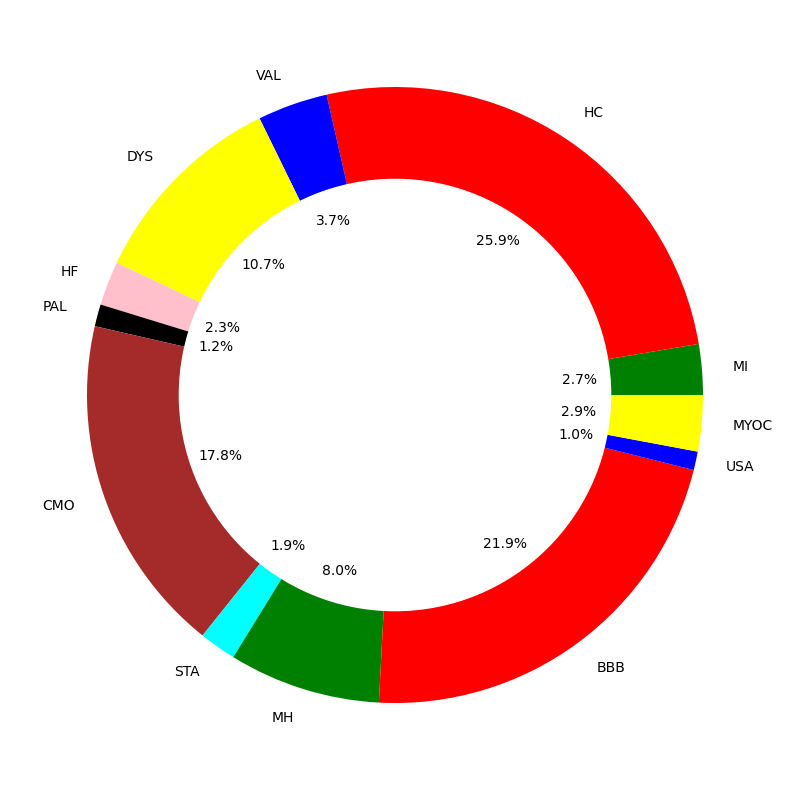

In [ ]:
# count the length of different directory inside dataset
Database_DIR = 'Images_DATABASE/'
image_dirs = ['MI/', 'HC/', 'VAL/', 'DYS/', 'HF/', 'PAL/', 'CMO/', 'STA/', 'MH/', 'BBB/', 'USA/', 'MYOC/']

no_of_files_in_dir=[]
for image_dir in image_dirs:
    path, dirs, files = next(os.walk(os.path.join(Database_DIR,image_dir)))
    no_of_files_in_dir.append(len(files)) 

print('Number of images in each directory={} and total number of images={}'.format(no_of_files_in_dir, sum(no_of_files_in_dir)))

labels = ['MI', 'HC', 'VAL', 'DYS', 'HF', 'PAL', 'CMO', 'STA', 'MH', 'BBB', 'USA', 'MYOC']
colors = ['green', 'red', 'blue', 'yellow', 'pink', 'black', 'brown', 'cyan', 'green', 'red', 'blue', 'yellow']

plot_pie_chart_of_data(no_of_files_in_dir,labels,colors, 'data_distribution.png')


In [ ]:
!zip -r /content/Images_DATABASE24.zip Images_DATABASE

  adding: Images_DATABASE/ (stored 0%)
  adding: Images_DATABASE/USA/ (stored 0%)
  adding: Images_DATABASE/USA/fig_02_re_15.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_30.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_14.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_9.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_19.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_1.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_29.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_23.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_36.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_16.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_4.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_7.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_2.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_33.png (deflated 9%)
  adding: Images_DATABASE/USA/fig_02_re_21.png (deflated 9%)
  adding